In [67]:
import pandas as pd
import numpy as np
import re
import html
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from nltk import bigrams, word_tokenize
from collections import Counter
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# from gensim.corpora import Dictionary
# from gensim.models import LdaModel
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# import nltk
# nltk.download('stopwords')

In [68]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Get data

In [69]:
df=pd.read_csv('20240329_S&P50_latest_10K_data_w_section_text.csv')
df.head()

,Unnamed: 0,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,...,business_text_clean,risk_text_clean,business_text_climatechange_count,risk_text_climatechange_count,business_text_greenhouse_count,risk_text_greenhouse_count,business_text_sustainability_count,risk_text_sustainability_count,business_any_keyword,risk_any_keyword
0,0,1,Microsoft,MSFT,https://www.microsoft.com,"$3,002,343,620,608",3002 B,2023.0,7/27/2023,6/30/2023,...,ITEM 1. B USINESS GENERAL Embracing Our Futur...,ITEM 1A. RIS K FACTORS Our operations and fin...,1,1,0,0,8,1,5,2
1,1,2,Apple Inc.,AAPL,https://www.apple.com,"$2,815,212,650,496",2815 B,2023.0,11/3/2023,9/30/2023,...,Item 1. Business Company Background The Compa...,"Item 1A. Risk Factors The Company’s business,...",0,3,0,1,0,0,0,3
2,2,3,Nvidia,NVDA,https://www.nvidia.com,"$1,793,541,144,576",1794 B,2023.0,2/24/2023,1/29/2023,...,ITEM 1. BUSINESS Our Company NVIDIA pioneered...,"ITEM 1A. RISK FACTORS In evaluating NVIDIA, t...",3,9,0,0,2,2,4,6
3,3,4,Amazon,AMZN,https://www.aboutamazon.com,"$1,760,768,032,768",1761 B,2023.0,2/2/2024,12/31/2023,...,Item 1. Business ##TABLE_END This Annual Repo...,Item 1A. Risk Factors ##TABLE_END Please care...,0,5,0,0,0,2,0,4
4,4,5,Alphabet Inc. (Class A),GOOGL,https://abc.xyz,"$1,754,293,862,400",1754 B,2023.0,1/31/2024,12/31/2023,...,ITEM 1. BUSINESS Overview As our founders Lar...,ITEM 1A. RISK FACTORS Our operations and fina...,3,3,0,0,10,2,7,3


## Check if all "business text" and "risk text" are available

In [127]:
df[df['business_text'].str.strip().isnull()]

,Unnamed: 0,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,...,risk_text_bigram_air_pollution,risk_text_bigram_autonomous_vehicle,risk_text_bigram_Autonomous_vehicle,business_text_bigram_any,risk_text_bigram_any,biz_with_no_bigram_mentions,risk_with_no_bigram_mentions,biz_to_risk_bigram_mention_ratio,biz_to_risk_bigram_mention_diff,bigram_more_biz_or_risk
5,5,6,Alphabet Inc. (Class C),GOOG,https://abc.xyz,"$1,753,911,394,304",1754 B,NaN,NaN,NaN,...,0,0,0,0,0,1,1,NaN,0,1
36,36,37,Walt Disney,DIS,https://www.thewaltdisneycompany.com,"$204,707,872,768",205 B,2023.0,1/24/2024,9/30/2023,...,0,0,0,0,0,1,1,NaN,0,1


In [128]:

df[df['risk_text'].str.strip().isnull()]

,Unnamed: 0,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,...,risk_text_bigram_air_pollution,risk_text_bigram_autonomous_vehicle,risk_text_bigram_Autonomous_vehicle,business_text_bigram_any,risk_text_bigram_any,biz_with_no_bigram_mentions,risk_with_no_bigram_mentions,biz_to_risk_bigram_mention_ratio,biz_to_risk_bigram_mention_diff,bigram_more_biz_or_risk
5,5,6,Alphabet Inc. (Class C),GOOG,https://abc.xyz,"$1,753,911,394,304",1754 B,NaN,NaN,NaN,...,0,0,0,0,0,1,1,NaN,0,1
36,36,37,Walt Disney,DIS,https://www.thewaltdisneycompany.com,"$204,707,872,768",205 B,2023.0,1/24/2024,9/30/2023,...,0,0,0,0,0,1,1,NaN,0,1


In [130]:
# Drop GOOG (becuase already including GOOL)
df = df[df['stock_symbol'] != 'GOOG']


## Fix data gap

In [133]:
# Manually add back Disney's text


disney_biz_text="""
ITEM 1. Business
The Walt Disney Company, together with its subsidiaries, is a diversified worldwide entertainment company with operations in three segments: Entertainment, Sports and Experiences.
The terms “Company”, “we”, “our” and “us” are used in this report to refer collectively to the parent company and the subsidiaries through which businesses are conducted.
Human Capital
The Company’s key human capital management objectives are to attract, retain and develop the highest quality talent. To support these objectives, the Company’s human resources programs are designed to develop talent to prepare them for critical roles and leadership positions for the future; reward and support employees through competitive pay, benefit and perquisite programs; enhance the Company’s culture through efforts aimed at making the workplace more engaging and inclusive; acquire talent and facilitate internal talent mobility to create a high-performing, diverse workforce; engage employees as brand ambassadors of the Company’s content, products and experiences; and evolve and invest in technology, tools and resources to enable employees at work.
The Company employed approximately 225,000 people as of September 30, 2023, of which approximately 167,000 were employed in the U.S. and approximately 58,000 were employed outside the U.S. Our global workforce is comprised of approximately 77% full time and 16% part time employees, with another 7% being seasonal employees. A significant number of employees in various parts of our businesses, including employees of our theme parks, and writers, directors, actors and production personnel for our productions are covered by collective bargaining agreements. In addition, some of our employees outside the U.S. are represented by works councils, trade unions or other employee associations.
Some of our key programs and initiatives to attract, develop and retain our diverse workforce include:
•Health, wellness, family resources and other benefits: Disney’s benefit offerings are designed to meet the varied and evolving needs of a diverse workforce across businesses and geographies while helping our employees care for themselves and their families. We provide:
◦Healthcare options aimed at improving quality of care while limiting out-of-pocket costs
◦Family care resources, such as childcare and senior care programs for employees, including access to onsite/community centers, enhanced back-up care choices to include personal caregivers, childcare referral assistance and center discounts, homework help, college preparation, support for students with special needs, a variety of parenting educational resources, long-term care coverage and a family building benefit supporting fertility treatments, adoptions or surrogacy
◦Free mental health and well-being resources, including onsite and virtual on-demand access to the Employee Assistance Program for employees and their dependents and access to digital applications to manage stress and encourage movement
◦Two Centers for Living Well facilities that offer convenient, on-demand access to board-certified physicians and counselors
◦Global Well-Being Week (introduced in 2022), a dedicated week for employees around the world to celebrate, learn and engage in well-being through in-person and virtual events and activities focused on physical, emotional, financial and social well-being
◦Access to a variety of well-being focused apps and platforms including our newest offering, Thrive Global, which is an innovative app that helps employees create long-term healthy habits and behaviors while improving their overall well-being and productivity
•Diversity, Equity and Inclusion (DE&I): Our DE&I objectives are to build teams that reflect the life experiences of our audiences, while employing and supporting a diverse array of voices in our creative and production teams. Our DE&I initiatives and programs include:
◦Reimagine Tomorrow, which is the Company’s digital destination for amplifying underrepresented voices and features some of Disney’s DE&I commitments and actions
◦Executive Incubator, Creative Talent Development and Inclusion, and the Disney Launchpad: Shorts Incubator, which are designed to create a pipeline of next-generation creative executives from underrepresented backgrounds
◦Employee development programs and fellowships for underrepresented talent
◦Innovative learning opportunities, which spark dialogue among employees, leaders, Disney talent and external experts
2
TABLE OF CONTENTS
◦Over 100 employee-led groups, which represent and support the diverse communities that make up our global workforce
◦The Disney Look appearance guidelines, which were updated to cultivate a more inclusive environment that encourages and celebrates authentic expressions of belonging among employees
•Disney Aspire: We support the long-term career aspirations of our hourly employees and further our commitment to strengthening the communities in which we work through our education investment program, Disney Aspire. We pay 100% of the tuition costs upfront for eligible participating employees at a variety of in-network learning providers and universities and reimburse employees for applicable books and fees. The program helps our employees achieve their goals professionally - whether at Disney or beyond - by equipping them with the skills they need to succeed in the rapidly changing 21st century career landscape. More than 15,000 current employees are enrolled and more than 3,800 current employees have graduated since the program launched in 2018. More than 3,100 current students and graduates have been internally promoted across the Company.
•Talent Development: We prioritize and invest in creating opportunities to help employees grow and build their careers through a multitude of training and development programs. These include online, instructor-led and on-the-job learning formats as well as executive talent and succession planning paired with an individualized development approach.
•Sustainability and Social Impact: The Company’s longstanding commitments to sustainability and social impact helps differentiate the Company as an employer. Our priorities include operating responsibly; investing in our people’s development and employee experience; diversity, equity and inclusion; environmental stewardship and conservation; and supporting our communities, with a focus on supporting children and families. Our approach seeks to connect these priorities with the Company’s businesses and employees and is reflected in our philanthropic giving. The Company also supports employees who give back to our communities with a generous U.S. matching gifts program, as well as Disney VoluntEARS, which rewards employees for their volunteer hours with the opportunity to direct not-for-profit donations from the Company to qualified non-profits of their choosing.
Environmental Sustainability
The Company has developed measurable environmental sustainability goals for 2030, based on our assessment of where the Company’s operations have the most significant environmental impacts and where we can most effectively mitigate those impacts. The Company’s goals encompass science-based targets for Scope 1, 2 and 3 emissions, water stewardship, waste reduction, sustainable design in construction and use of more sustainable materials in our products.
ENTERTAINMENT
The Entertainment segment generally encompasses the Company’s non-sports focused global film, television and direct-to-consumer (DTC) video streaming content production and distribution activities.
The significant lines of business within Entertainment are as follows:
•Linear Networks
◦Domestic: ABC Television Network (ABC Network); Disney, Freeform, FX and National Geographic (owned 73% by the Company) branded television channels; and eight owned ABC television stations
◦International: Disney, Fox (which will be rebranded in fiscal 2024, primarily to FX or Star), FX, National Geographic (owned 73% by the Company) and Star branded general entertainment television channels outside of the U.S.
◦A 50% equity investment in A+E Television Networks (A+E), which operates cable channels including A&E, HISTORY and Lifetime
•Direct-to-Consumer
◦Disney+: a global DTC service that primarily offers general entertainment and family programming. In certain Latin American countries, we offer Disney+ as well as Star+, a general entertainment service that also has sports programming
◦Disney+ Hotstar: a DTC service primarily in India that offers general entertainment, family and sports programming
◦Hulu (owned 67% by the Company): a U.S. DTC service that offers general entertainment and family programming and a digital over-the-top (OTT) service that includes live linear streams of cable networks and the major broadcast networks
3
TABLE OF CONTENTS
•Content Sales/Licensing
◦Sale/licensing of film and episodic content to third-party television and video-on-demand (TV/VOD) services
◦Theatrical distribution
◦Home entertainment distribution: DVD and Blu-ray discs, electronic home video licenses and video-on-demand (VOD) rentals
◦Staging and licensing of live entertainment events on Broadway and around the world (Stage Plays)
◦Intersegment allocation of revenues from the Experiences segment, which is meant to reflect royalties on consumer products merchandise licensing revenues generated on intellectual property (“IP”) created by the Entertainment segment
◦Music distribution
◦Post-production services by Industrial Light & Magic and Skywalker Sound
Entertainment also includes the following activities that are reported with Content Sales/Licensing:
•National Geographic magazine and online business (owned 73% by the Company)
•A 30% ownership interest in Tata Play Limited, which operates a direct-to-home satellite distribution platform in India
The significant revenues of Entertainment are as follows:
•Affiliate fees - Fees charged to multi-channel video programming distributors (i.e. cable, satellite, telecommunications and digital over-the-top (e.g. YouTube TV) service providers) (MVPDs) for the right to deliver our programming to their customers. Linear Networks also generates revenues from fees charged to television stations affiliated with ABC Network.
•Subscription fees - Fees charged to customers/subscribers for our DTC streaming services
•Advertising - Sales of advertising time/space
•TV/VOD distribution - Licensing fees for the right to use our film and episodic content
•Theatrical distribution - Rentals from licensing our films to theaters
•Home entertainment distribution - Sales and rentals of our film and episodic content to retailers and through distributors
•Other revenue - Revenues from licensing our music, ticket sales from stage play performances, fees from licensing our IP for use in stage plays, sales of post-production services and the allocation of consumer products merchandise licensing revenues
The significant expenses of Entertainment are as follows:
•Operating expenses, consisting primarily of programming and production costs, technology support costs, operating labor, distribution costs and costs of sales. Programming and production costs include the following:
◦Amortization of capitalized production costs
◦Amortization of the costs of licensed programming rights
◦Subscriber-based fees for programming our Hulu Live service, including fees paid by Hulu to the Sports segment and other Entertainment segment businesses for the right to air their linear networks on Hulu Live
◦Production costs related to live programming (primarily news)
◦Amortization of participations and residual obligations
◦Fees paid to the Sports segment to program ESPN on ABC and certain sports content on Star+
•Selling, general and administrative costs, including marketing costs
•Depreciation and amortization
Linear Networks
The majority of Linear Networks revenue is derived from affiliate fees and advertising. The Company’s Linear Networks businesses provide programming under multi-year licensing agreements with MVPDs and/or affiliated television stations that are generally based on contractually specified rates on a per subscriber basis. The amounts that we can charge for our networks are largely dependent on the quality and quantity of programming that we can provide and the competitive market for programming services. The ability to sell advertising time and the rates received are primarily dependent on the size and nature of the audience that the network can deliver to the advertiser as well as overall advertiser demand.
4
TABLE OF CONTENTS
Domestic Linear Networks
ABC Network
ABC Network distributes programming to approximately 240 local affiliated television stations and to our eight owned television stations, which collectively reach almost 100% of U.S. television households. ABC Network programming is aired in the primetime, daytime, late night, news and sports “dayparts”. ESPN programs the sports daypart on the ABC Network, which is branded ESPN on ABC.
ABC Network produces a variety of primetime specials, news and daytime programming.
Disney Channels
Branded television channels include: Disney Channel; Disney Junior; and Disney XD (collectively Disney Channels).
Disney Channel - the Disney Channel airs original series and movie programming 24 hours a day targeted to kids ages 2 to 14. The channel features live-action comedy series, animated programming and preschool series as well as original movies and theatrical films.
Disney Junior - the Disney Junior channel airs programming 24 hours a day targeted to kids ages 2 to 7 and their parents and caregivers. The channel features animated and live-action programming that blends Disney’s storytelling and characters with learning. Disney Junior also airs as a programming block on the Disney Channel.
Disney XD - the Disney XD channel airs programming 24 hours a day targeted to kids ages 6 to 11. The channel features a mix of live-action and animated programming.
Freeform
Freeform is a channel targeted to viewers ages 18 to 34 that airs original, Company owned (“library”) and licensed television series, films and holiday programming events.
FX Channels
Branded television channels include: FX; FXM; and FXX (collectively FX Channels), which air a mix of original, library and licensed television series and films.
National Geographic Channels
Branded television channels include: National Geographic; Nat Geo Wild; and Nat Geo Mundo (collectively National Geographic Channels). National Geographic Channels air scripted and documentary programming on such topics as natural history, adventure, science, exploration and culture.
The number of subscribers (in millions) for the significant domestic branded channels are as follows:
Subscribers(1)
Disney
Disney Channel	71
Disney Junior(2)
52
Disney XD(2)
51
Freeform(2)
71
FX Channels
FX	72
FXX(2)
68
FXM(2)
43
National Geographic Channels
National Geographic	71
National Geographic Wild(2)
42

(1)Based on Nielsen Media Research estimates as of September 2023. Estimates include traditional MVPD and the majority of digital OTT subscriber counts.
(2)The Company renewed its MVPD agreement with an affiliate during September 2023, under which the affiliate will no longer distribute these channels. Nielsen Media Research estimates as of September 2023 do not reflect the impact of this agreement.
5
TABLE OF CONTENTS
Domestic Television Stations
The Company owns eight television stations, six of which are located in the top ten television household markets in the U.S. Our television stations collectively reach approximately 20% of U.S. television households.
The stations we own are as follows:
TV Station		Market
Television Market
Ranking(1)
WABC		New York, NY		1
KABC		Los Angeles, CA		2
WLS		Chicago, IL		3
WPVI		Philadelphia, PA		4
KTRK		Houston, TX		7
KGO		San Francisco, CA		10
WTVD		Raleigh-Durham, NC		23
KFSN		Fresno, CA		53

(1)Based on Nielsen Media Research, U.S. Television Household Estimates, January 1, 2023
International Linear Networks
International Linear Networks use content from the Company’s various studios, including library titles, as well as content acquired from third parties. The Company operates approximately 285 general entertainment and family channels outside the U.S. in approximately 40 languages and 190 countries/territories.
General Entertainment
General Entertainment channels include Fox (which will be rebranded in fiscal 2024, primarily to FX or Star), FX, National Geographic and Star branded channels, which air a variety of scripted, reality and documentary programming. As of September 2023 and 2022, the estimated number of unique subscribers for our general entertainment channels, based on internal management reports, are 270 million and 315 million, respectively.
Family
Family channels include Disney Channel and Disney Junior, which air a variety of animated and live action original series and movies targeted to kids ages 2 to 14 and their parents and caregivers. As of September 2023 and 2022, the estimated number of unique subscribers for our family channels, based on internal management reports, are 225 million and 220 million, respectively.
Equity Investments
The most significant equity investment at Linear Networks is A+E. The Company’s share of A+E’s financial results are reported as “Equity in the income (loss) of investees, net” in the Company’s Consolidated Statements of Operations.
A+E is owned 50% by the Company and 50% by Hearst. A+E operates a variety of cable channels:
•A&E – which generally offers unscripted entertainment programming
•HISTORY – which offers original unscripted series and event-driven specials
•Lifetime and Lifetime Movie Network (LMN) – which offer female-focused programming
•FYI – which offers contemporary lifestyle programming
A+E programming is available in approximately 200 countries and territories. A+E’s networks are distributed internationally under multi-year licensing agreements with MVPDs. A+E programming is also sold to international TV/VOD services.
6
TABLE OF CONTENTS
The number of domestic subscribers (in millions) for A+E channels are as follows:
Subscribers(1)
A&E	65
HISTORY	65
Lifetime	65
LMN	49
FYI	37

(1)Based on Nielsen Media Research estimates as of September 2023. Estimates include traditional MVPD and the majority of digital OTT subscriber counts.
Direct-to-Consumer
Disney+, Disney+ Hotstar and Hulu are subscription services that provide video streaming of general entertainment and family programming. Disney+ and Disney+ Hotstar also provide video streaming of international sports programming. The services are offered individually or in various bundles, which may include ESPN+ (see Sports segment discussion), to customers directly or through third-party distributors on mobile and internet connected devices. The majority of Direct-to-Consumer revenue is derived from subscription fees and advertising.
Disney+ (including Star+ in Latin America)
Disney+ is a subscription-based DTC service with Disney, Pixar, Marvel, Star Wars and National Geographic branded programming, which are all top-level selections or “tiles” within the Disney+ interface. Outside the U.S. and Latin America, Disney+ also includes a Star branded tile, which features general entertainment programming.
Star+ is a standalone DTC service in Latin America with a variety of general entertainment and family content and live sports programming.
Disney+ (including Star+) is also referred to as Disney+ Core.
As of September 30, 2023, the estimated number of paid Disney+ Core subscribers, based on internal management reports, was approximately 113 million.
Disney+ Hotstar
Disney+ Hotstar is a subscription-based DTC service available in India, Indonesia, Malaysia, Philippines and Thailand. Programming includes television shows, movies, sports and original series in approximately ten languages, in addition to gaming and social features. Disney+ Hotstar has exclusive streaming rights to certain cricket programming.
As of September 30, 2023, the estimated number of paid Disney+ Hotstar subscribers, based on internal management reports, was approximately 38 million.
Disney+ Core and Disney+ Hotstar offer content from the Company’s various studios, including library titles, as well as content acquired from third parties.
The majority of Disney+ Core and Disney+ Hotstar revenue is derived from subscription fees and, to a lesser extent, Advertising. The Company launched an ad-supported Disney+ service in the U.S. in December 2022 and in select European markets and in Canada in November 2023. The Company plans to launch an ad-supported Disney+ service in additional international markets in calendar 2024.
Hulu
Hulu is a domestic subscription-based DTC service with general entertainment content from the Company’s various studios as well as content licensed from third parties. Hulu’s revenue is primarily derived from subscription fees and Advertising. Hulu offers subscription VOD (SVOD) services with or without advertising in addition to a digital OTT MVPD (Live TV) service. The Live TV service is available with either of Hulu’s SVOD services and includes live linear streams of cable networks and the major broadcast networks. In addition, Hulu offers subscriptions to premium services such as Max, Cinemax, Starz and Showtime, which can be added to the Hulu service. Certain programming from ABC Network, Freeform and FX Channels is also available on the Hulu SVOD service one day after the linear airing on these channels. As of September 30, 2023, the estimated number of paid Hulu subscribers, based on internal management reports, was approximately 49 million.
The Company has 67% ownership and full operational control of Hulu. NBC Universal (NBCU) owns the remaining 33% of Hulu. In November 2023, NBCU exercised its put right to require the Company to purchase NBCU’s interest in Hulu (see Note 2 of the Consolidated Financial Statements for additional information).
7
TABLE OF CONTENTS
Content Sales/Licensing and Other
The majority of Content Sales/Licensing revenue is derived from TV/VOD, theatrical and home entertainment distribution. In addition, revenue is generated from music distribution, stage plays and post-production services through Industrial Light & Magic and Skywalker Sound.
The Company also publishes National Geographic magazine, which is reported with Content Sales/Licensing.
TV/VOD Distribution
We license our content to third-party television networks, television stations and other video service providers for distribution to viewers on television or a variety of internet-connected devices, including through other DTC services.
Theatrical Distribution
The Company licenses full-length live-action and animated films to theaters globally. Cumulatively through September 30, 2023, the Company has released approximately 1,100 full-length live-action films and 100 full-length animated films. In the domestic and most major international markets, we generally distribute and market our films directly. In certain international markets our films are distributed by independent companies. In some territories, certain films may be exclusively distributed on our DTC streaming services. During fiscal 2024, we expect to release approximately 15 films, although the ultimate number of releases will depend on when productions resume following the writers/actors’ work stoppages.
The Company incurs significant marketing and advertising costs before and throughout the theatrical release of a film in an effort to generate public awareness of the film, to increase the public’s intent to view the film and to help generate consumer interest in the subsequent home entertainment and other ancillary markets. These costs are expensed as incurred, which may result in a loss on a film in the theatrical markets, including in periods prior to the theatrical release of the film.
Home Entertainment Distribution
We distribute the Company’s film and episodic content in home entertainment markets on DVD and Blu-ray disc, through electronic home video licenses and VOD rentals globally.
Domestically and internationally, we distribute directly to retailers and through independent distribution companies. Electronic formats of our film and episodic content may be purchased through e-tailers such as Apple and Amazon, and MVPDs, such as Comcast and DirecTV, and physical formats are generally sold to retailers, such as Walmart and Target. The Company also operates Disney Movie Club, which sells DVD/Blu-ray discs directly to consumers in the U.S. and Canada.
Distribution of film content in the home entertainment window generally starts within three months after the theatrical release. Electronic formats are typically available approximately four to eight weeks ahead of the physical release. We also license titles to VOD e-tailers concurrent with physical home entertainment distribution.
Distribution of episodic content in the home entertainment window includes electronic sales of season passes that can be purchased prior to, during and after the broadcast season with individual episodes typically available to season pass customers shortly after the initial airing of the show in each territory. Access to individual episodes is also available for electronic purchase shortly after the initial airing in each territory.
Disney Theatrical Group
Disney Theatrical Group develops, produces and licenses live entertainment events on Broadway and around the world. Productions include The Lion King, Frozen, Aladdin and Beauty and the Beast.
Disney Theatrical Group also licenses the Company’s IP to Feld Entertainment, the producer of Disney On Ice and Marvel Universe Live!.
Disney Music Group
The Disney Music Group encompasses all aspects of the Company’s music commercialization and marketing including: recorded music (Walt Disney Records and Hollywood Records); music publishing; and concerts. Disney Music Group distributes music both physically and digitally and also licenses music throughout the world in various forms of media, including: television; print; gaming; and consumer products.
Equity Investment
The Company has a 30% effective interest in Tata Play Limited, which operates a direct-to-home satellite distribution platform in India.
Content Production and Acquisition
Produced content primarily consists of original films and episodic programs, network news and daytime/nighttime content and licensed content includes acquired episodic programming rights. Original content is generally produced under the following banners: ABC Signature; Disney Branded Television; FX Productions; Lucasfilm; Marvel; National Geographic Studios; Pixar;
8
TABLE OF CONTENTS
Searchlight Pictures; Twentieth Century Studios; 20th Television; and Walt Disney Pictures. Original content is also commissioned and produced by various third-party studios. Program development is carried out in collaboration with writers, producers and creative teams.
Costs to produce content are generally capitalized and allocated across Entertainment’s businesses based on the estimated relative value of the distribution windows.
Generally, the Company has full production and distribution rights to its IP. However, prior to the Company’s acquisition of Marvel, Sony Pictures Entertainment licensed from Marvel the rights to produce and distribute Spider-Man films in all windows except for the merchandise rights, which the Company retains.
The Company has a significant library of content spanning approximately 100 years of production history as well as acquired libraries. The library of content includes approximately 5,100 live-action film titles and 400 animated film titles, as well as episodic series with four or more seasons (approximately 75 dramas, 55 comedies, 35 non-scripted series, 15 animated series and 10 live-action series). In addition, the library includes approximately 100 series and 65 films that were produced for initial distribution on our DTC platforms.
In fiscal 2024, the Company plans to produce or commission approximately 225 episodic and film titles, although the ultimate number will depend on when productions resume following the writers/actors’ work stoppages. The vast majority of our productions will be distributed on our Linear Networks and/or DTC platforms or theatrically. Programming is also produced for third parties, which typically have domestic linear distribution rights while the Company retains domestic VOD and international distribution rights. We also license, acquire or produce local content for use in various countries/territories.
Competition and Seasonality
Linear Networks and Direct-to-Consumer compete for viewers’ attention and audience share primarily with other television networks, independent television stations and other media, such as other DTC streaming services, social media and video games. With respect to the sale of advertising time, we compete with other television networks, independent television stations, MVPDs, other DTC streaming services and other advertising media such as digital content, newspapers, magazines, radio and billboards. Our television and radio stations primarily compete for audiences and advertisers in local market areas.
Linear Networks compete with other networks for carriage by MVPDs. The Company’s contractual agreements with MVPDs are renewed or renegotiated from time to time in the ordinary course of business. Consolidation and other market conditions in the cable, satellite and telecommunication distribution industry, including subscriber trends, and other factors may adversely affect the Company’s ability to obtain and maintain contractual terms for the distribution of its various programming services that are as favorable as those currently in place.
Content Sales/Licensing businesses compete with all forms of entertainment and a significant number of companies produce and/or distribute theatrical and episodic content, distribute products in the home entertainment market, provide pay TV/VOD services, and produce music and live theater.
The operating results of Content Sales/Licensing fluctuate due to the timing and performance of releases in the theatrical, home entertainment and television markets. Release dates are determined by several factors, including competition and the timing of vacation and holiday periods.
We also compete with other media and entertainment companies, independent production companies and VOD services for creative and performing talent, story properties, show concepts, scripted and other programming, advertiser support, production facilities and exhibition outlets that are essential to the success of our Entertainment businesses.
Advertising revenues at Linear Networks and Direct-to-Consumer are subject to seasonal advertising patterns and changes in viewership levels. In general, domestic advertising revenues are typically somewhat higher during the fall and somewhat lower during the summer months. Affiliate revenues vary with the subscriber trends of MVPDs.
Sports
The Sports segment generally encompasses the Company’s sports-focused global television and DTC video streaming content production and distribution activities.
The significant lines of business within Sports are as follows:
•ESPN (generally owned 80% by the Company)
◦Domestic:
▪Eight ESPN-branded television channels
▪ESPN on ABC (sports programmed on the ABC Network by ESPN)
▪ESPN+ DTC video streaming service
9
TABLE OF CONTENTS
◦International: ESPN-branded channels outside of the U.S.
•Star: Star-branded sports channels in India
The significant revenues of Sports are as follows:
•Affiliate fees
•Advertising
•Subscription fees
•Other revenue - Fees from the following activities: pay-per-view events on ESPN+, sub-licensing of sports rights, programming ESPN on ABC and licensing the ESPN brand
The significant expenses of Sports are as follows:
•Operating expenses, consisting primarily of programming and production costs, technology support costs, operating labor and distribution costs. Programming and production costs include amortization of licensed sports rights and production costs related to live sports and other sports-related programming.
•Selling, general and administrative costs, including marketing costs
•Depreciation and amortization
Domestic ESPN
Branded television channels include eight 24-hour domestic television sports channels: ESPN and ESPN2 (both of which are dedicated to professional and college sports as well as sports news and original programming); ESPNU (which is dedicated to college sports); ESPNEWS (which re-airs select ESPN studio shows and airs a variety of other programming); SEC Network (which is dedicated to Southeastern Conference college athletics); ACC Network (which is dedicated to Atlantic Coast Conference college athletics); ESPN Deportes (which airs professional and college sports as well as studio shows in Spanish); and Longhorn Network (which is dedicated to The University of Texas athletics). In addition, ESPN programs ESPN on ABC and recognizes the direct revenues and costs for this programming and receives a fee from the ABC Network, which is eliminated in consolidation.
The Company has various sports programming rights, which are used to produce content aired on ESPN television networks and ESPN+, including live events and sports news. Rights include the National Football League (NFL), college football (including bowl games and the College Football Playoff) and basketball, the National Basketball Association (NBA), mixed martial arts, Major League Baseball (MLB), the National Hockey League (NHL), soccer, Top Rank Boxing, US Open Tennis, the Masters golf tournament, the Wimbledon Championships, the Professional Golfers’ Association (PGA) Championship and the Women’s National Basketball Association (WNBA).
The number of subscribers (in millions) for the significant domestic branded channels are as follows:
Subscribers
ESPN(1)
71
ESPN2(1)
71
ESPNU(1)
50
ESPNEWS(2)
53
SEC Network(2)
48
ACC Network(2)
46

(1)Based on Nielsen Media Research estimates as of September 2023. Estimates include traditional MVPD and the majority of digital OTT subscriber counts.
(2)Because Nielsen Media Research does not measure this channel, estimated subscribers are according to SNL Kagan as of December 2022.
ESPN+ is a domestic subscription-based DTC service offering thousands of live sporting events, on-demand sports content and other original programming. The service is offered individually or in various bundles with Disney+ and Hulu to customers directly or through third-party distributors on mobile and internet connected devices. ESPN+ revenue is derived from subscription fees, pay-per-view fees and, to a lesser extent, advertising. Live events available through the service include mixed martial arts, soccer, hockey, boxing, baseball, college sports, golf, tennis and cricket. ESPN+ is currently the exclusive distributor for Ultimate Fighting Championship (UFC) pay-per-view events in the U.S. As of September 30, 2023, the estimated number of paid ESPN+ subscribers, based on internal management reports, was approximately 26 million.
10
TABLE OF CONTENTS
International ESPN
The Company operates approximately 40 ESPN branded sports channels outside the U.S. in 4 languages and approximately 105 countries/territories. Channels previously branded Fox are now branded ESPN. In the Netherlands, the ESPN branded channels are operated by Eredivisie Media & Marketing CV (EMM) (owned 51% by the Company), which has the media and sponsorship rights of the Dutch Premier League for soccer. Rights include various soccer leagues (including English Premier League, LaLiga, Bundesliga and multiple UEFA leagues). As of September 2023, the estimated number of subscribers to ESPN branded channels outside the U.S., based on internal management reports, was approximately 59 million.
Star
The Company operates 10 Star branded sports channels in India, in 4 languages. Star has rights to various sports programming, primarily cricket and soccer. As of September 2023, the estimated number of subscribers to Star branded channels, based on internal management reports, was 82 million.
Equity Investments
The most significant equity investment at Sports is a 30% interest in CTV Specialty Television, Inc. (CTV). The Company’s share of CTV’s financial results is reported as “Equity in the income (loss) of investees, net” in the Company’s Consolidated Statements of Operations. CTV operates television networks in Canada, including The Sports Networks (TSN) 1-5, Le Réseau des Sports (RDS), RDS2, RDS Info, Discovery Canada, Discovery Science and Animal Planet Canada.
Investments
In fiscal 2023, the Company entered into an agreement with PENN Entertainment, Inc. (PENN), under which the Company will earn advertising and licensing revenues from providing promotional services and the ESPN BET trademark to PENN in connection with its operation of a sportsbook. In addition, the Company received warrants to purchase equity in PENN, which vest over the term of the agreement. The warrants are recorded at fair market value and adjustments to fair market value are reported as “Interest expense, net” in the Company’s Consolidated Statements of Operations.
Competition and Seasonality
Sports competes for viewers’ attention and audience share primarily with other television networks, independent television stations and other media, such as other DTC streaming services, social media and video games. With respect to the sale of advertising time, we compete with other television networks, independent television stations, MVPDs and other advertising media such as digital content, newspapers, magazines, radio and billboards.
The Sports television networks compete with other networks for carriage by MVPDs. The Company’s contractual agreements with MVPDs are renewed or renegotiated from time to time in the ordinary course of business. Consolidation and other market conditions in the cable, satellite and telecommunication distribution industry and other factors may adversely affect the Company’s ability to obtain and maintain contractual terms for the distribution of its various programming services that are as favorable as those currently in place.
We also compete with other media and entertainment companies and VOD services for sports rights, creative and performing talent and other programming, advertiser support and production facilities that are essential to the success of our Sports businesses.
Advertising revenues are subject to changes in viewership levels and the demand for sports programming. Advertising revenues generated from sports programming are also impacted by the timing of sports seasons and events, which timing may vary throughout the year or may take place periodically (e.g. biannually, quadrennially). Affiliate revenues vary with the subscriber trends of MVPDs.
EXPERIENCES
The significant lines of business within Experiences are as follows:
•Parks & Experiences:
◦Domestic:
▪Theme parks and resorts:
•Walt Disney World Resort in Florida
•Disneyland Resort in California
▪Experiences:
•Disney Cruise Line
•Disney Vacation Club
•National Geographic Expeditions (owned 73% by the Company) and Adventures by Disney
11
TABLE OF CONTENTS
•Aulani, a Disney Resort & Spa in Hawaii
◦International:
▪Theme parks and resorts:
•Disneyland Paris
•Hong Kong Disneyland Resort (48% ownership interest and consolidated in our financial results)
•Shanghai Disney Resort (43% ownership interest and consolidated in our financial results)
•In addition, the Company licenses its IP to a third party to operate Tokyo Disney Resort
•Consumer Products:
◦Licensing of our trade names, characters, visual, literary and other IP to various manufacturers, game developers, publishers and retailers throughout the world, for use on merchandise, published materials and games
◦Sale of branded merchandise through online, retail and wholesale businesses, and development and publishing of books, comic books and magazines (except National Geographic magazine, which is reported in Entertainment)
The significant revenues of Experiences are as follows:
•Theme park admissions - Sales of tickets for admission to our theme parks and for premium access to certain attractions (e.g. Genie+ and Lightning Lane)
•Resorts and vacations - Sales of room nights at hotels, sales of cruise and other vacations and sales and rentals of vacation club properties
•Parks & Experiences merchandise, food and beverage - Sales of merchandise, food and beverages at our theme parks and resorts and cruise ships
•Merchandise licensing and retail:
◦Merchandise licensing - Royalties from licensing our IP for use on consumer goods
◦Retail - Sales of merchandise through internet shopping sites (generally branded shopDisney) and at The Disney Store, as well as to wholesalers (including books, comic books and magazines)
•Parks licensing and other - Revenues from sponsorships and co-branding opportunities, real estate rent and sales and royalties earned on Tokyo Disney Resort revenues
The significant expenses of Experiences are as follows:
•Operating expenses, consisting primarily of operating labor, costs of goods sold, infrastructure costs, supplies, commissions and entertainment offerings. Infrastructure costs include technology support costs, repairs and maintenance, property taxes, utilities and fuel, retail occupancy costs, insurance and transportation
•Selling, general and administrative costs, including marketing costs
•Depreciation and amortization
Significant capital investments:
•In recent years, the majority of the Company’s capital spend has been at our parks and experiences business, which is principally for theme park and resort expansion, new attractions, cruise ships, capital improvements and systems infrastructure.
Parks & Experiences
Walt Disney World Resort
The Walt Disney World Resort is located approximately 20 miles southwest of Orlando, Florida, on approximately 25,000 acres of land. The resort includes theme parks (the Magic Kingdom, EPCOT, Disney’s Hollywood Studios and Disney’s Animal Kingdom); hotels; vacation club properties; a retail, dining and entertainment complex (Disney Springs); a sports complex; conference centers; campgrounds; golf courses; water parks; and other recreational facilities designed to attract visitors for an extended stay.
The Walt Disney World Resort is marketed through a variety of international, national and local advertising and promotional activities. A number of attractions and restaurants in each of the theme parks are sponsored or operated by other companies under multi-year agreements.
Magic Kingdom — The Magic Kingdom consists of six themed areas: Adventureland, Fantasyland, Frontierland, Liberty Square, Main Street USA and Tomorrowland. Each land provides a unique guest experience featuring themed attractions, restaurants, merchandise shops and entertainment experiences.
12
TABLE OF CONTENTS
EPCOT — EPCOT consists of four major themed areas: World Showcase, World Celebration, World Nature and World Discovery. All areas feature themed attractions, restaurants, merchandise shops and entertainment experiences. Countries represented with pavilions include Canada, China, France, Germany, Italy, Japan, Mexico, Morocco, Norway, the United Kingdom and the U.S. The Journey of Water, inspired by Moana, opened in October 2023 as part of a multi-year transformation at EPCOT.
Disney’s Hollywood Studios — Disney’s Hollywood Studios consists of eight themed areas: Animation Courtyard, Commissary Lane, Echo Lake, Grand Avenue, Hollywood Boulevard, Star Wars: Galaxy’s Edge, Sunset Boulevard and Toy Story Land. The areas provide behind-the-scenes glimpses of Hollywood-style action through various shows and attractions and offer themed food service, merchandise shops and entertainment experiences.
Disney’s Animal Kingdom — Disney’s Animal Kingdom consists of a 145-foot tall Tree of Life centerpiece surrounded by five themed areas: Africa, Asia, DinoLand USA, Discovery Island and Pandora - The World of Avatar. Each themed area contains attractions, restaurants, merchandise shops and entertainment experiences. The park features more than 300 species of live mammals, birds, reptiles and amphibians and 3,000 varieties of vegetation.
Hotels, Vacation Club Properties and Other Resort Facilities — As of September 30, 2023, the Company owned and operated 18 resort hotels and vacation club facilities at the Walt Disney World Resort, with approximately 23,000 rooms and 3,600 vacation club units. Resort facilities include 500,000 square feet of conference meeting space and Disney’s Fort Wilderness camping and recreational area, which offers approximately 800 campsites.
Disney Springs is an approximately 120-acre retail, dining and entertainment complex and consists of four areas: Marketplace, The Landing, Town Center and West Side. The areas are home to more than 150 venues including the 64,000-square-foot World of Disney retail store. Most of the Disney Springs facilities are operated by third parties that pay rent to the Company.
Ten independently-operated hotels with approximately 7,000 rooms are situated on property leased from the Company.
ESPN Wide World of Sports Complex is a 230-acre center that hosts professional caliber training and competitions, festival and tournament events and interactive sports activities. The complex, which welcomes both amateur and professional athletes, accommodates multiple sporting events, including baseball, basketball, football, soccer, softball, tennis and track and field. It also includes a stadium, as well as two venues designed for cheerleading, dance competitions and other indoor sports.
Other recreational amenities and activities available at the Walt Disney World Resort include three championship golf courses, miniature golf courses, full-service spas, tennis, sailing, swimming, horseback riding and a number of other sports and leisure time activities. The resort also includes two water parks: Disney’s Blizzard Beach and Disney’s Typhoon Lagoon.
Disneyland Resort
The Company owns 489 acres and has rights under a long-term lease for use of an additional 52 acres of land in Anaheim, California. The Disneyland Resort includes two theme parks (Disneyland and Disney California Adventure), three resort hotels and a retail, dining and entertainment complex (Downtown Disney).
The Disneyland Resort is marketed through a variety of international, national and local advertising and promotional activities. A number of the attractions and restaurants in the theme parks are sponsored or operated by other companies under multi-year agreements.
Disneyland — Disneyland consists of nine themed areas: Adventureland, Critter Country, Fantasyland, Frontierland, Main Street USA, Mickey’s Toontown, New Orleans Square, Star Wars: Galaxy’s Edge and Tomorrowland. These areas feature themed attractions, restaurants, merchandise shops and entertainment experiences.
Disney California Adventure — Disney California Adventure is adjacent to Disneyland and includes eight themed areas: Avengers Campus, Buena Vista Street, Cars Land, Grizzly Peak, Hollywood Land, Paradise Gardens Park, Pixar Pier and San Fransokyo Square. These areas include themed attractions, restaurants, merchandise shops and entertainment experiences.
Hotels, Vacation Club Units and Other Resort Facilities — Disneyland Resort includes three Company owned and operated hotels and vacation club facilities with approximately 2,400 rooms, 180 vacation club units and 180,000 square feet of conference meeting space.
Downtown Disney is a themed 15-acre retail, entertainment and dining complex with approximately 30 venues located adjacent to both Disneyland and Disney California Adventure. Most of the Downtown Disney facilities are operated by third parties that pay rent to the Company.
13
TABLE OF CONTENTS
Aulani, a Disney Resort & Spa
Aulani, a Disney Resort & Spa is a family resort on a 21-acre oceanfront property on Oahu, Hawaii featuring approximately 350 hotel rooms, an 18,000-square-foot spa and 12,000 square feet of conference meeting space. The resort also has approximately 480 vacation club units.
Disneyland Paris
Disneyland Paris is located on approximately 5,200-acres in Marne-la-Vallée, approximately 20 miles east of Paris, France. The land is being developed pursuant to a master agreement with French governmental authorities. Disneyland Paris includes two theme parks (Disneyland Park and Walt Disney Studios Park); seven themed resort hotels; two convention centers; a shopping, dining and entertainment complex (Disney Village); and a 27-hole golf facility. Of the 5,200 acres comprising the site, approximately half have been developed to date, including a planned community (Val d’Europe).
Disneyland Park — Disneyland Park consists of five themed areas: Adventureland, Discoveryland, Fantasyland, Frontierland and Main Street USA. These areas include themed attractions, restaurants, merchandise shops and entertainment experiences.
Walt Disney Studios Park — Walt Disney Studios Park includes five themed areas: Front Lot, Production Courtyard, Toon Studio, Worlds of Pixar and Avengers Campus. These areas each include themed attractions, restaurants, merchandise shops and entertainment experiences. Walt Disney Studios Park is undergoing a multi-year expansion that will include a new themed area based on Frozen.
Hotels and Other Facilities — Disneyland Paris operates seven resort hotels, with approximately 5,750 rooms and 250,000 square feet of conference meeting space. In addition, five on-site hotels that are owned and operated by third parties provide approximately 1,500 rooms.
Disney Village is an approximately 500,000-square-foot retail, dining and entertainment complex located between the theme parks and the hotels. A number of the Disney Village facilities are operated by third parties that pay rent to the Company.
Val d’Europe is a planned community near Disneyland Paris that is being developed in phases. Val d’Europe currently includes a regional train station, hotels and a town center consisting of a shopping center as well as office, commercial and residential space. Third parties operate these developments on land leased or purchased from the Company.
Hong Kong Disneyland Resort
The Company owns a 48% interest in Hong Kong Disneyland Resort and the Government of the Hong Kong Special Administrative Region (HKSAR) owns a 52% interest. The resort is located on 310 acres on Lantau Island and is in close proximity to the Hong Kong International Airport and the Hong Kong-Zhuhai-Macau Bridge. Hong Kong Disneyland Resort includes one theme park and three themed resort hotels. A separate Hong Kong subsidiary of the Company is responsible for managing Hong Kong Disneyland Resort. The Company is entitled to receive royalties and management fees based on the operating performance of Hong Kong Disneyland Resort.
Hong Kong Disneyland — Hong Kong Disneyland consists of eight themed areas: Adventureland, Fantasyland, Grizzly Gulch, Main Street USA, Mystic Point, Tomorrowland, Toy Story Land and World of Frozen, which opened in November 2023. These areas feature themed attractions, restaurants, merchandise shops and entertainment experiences.
Hotels — Hong Kong Disneyland Resort includes three themed hotels with approximately 1,750 rooms and 16,000 square feet of conference meeting space.
Shanghai Disney Resort
The Company owns a 43% interest in Shanghai Disney Resort and Shanghai Shendi (Group) Co., Ltd (Shendi) owns a 57% interest. The resort is located in the Pudong district of Shanghai on approximately 1,000 acres of land, which includes the Shanghai Disneyland theme park; two themed resort hotels; a retail, dining and entertainment complex (Disneytown); and an outdoor recreation area. A management company, in which the Company has a 70% interest and Shendi has a 30% interest, is responsible for operating the resort and receives a management fee based on the operating performance of Shanghai Disney Resort. The Company is also entitled to royalties based on the resort’s revenues.
Shanghai Disneyland — Shanghai Disneyland consists of seven themed areas: Adventure Isle, Fantasyland, Gardens of Imagination, Mickey Avenue, Tomorrowland, Toy Story Land and Treasure Cove. These areas feature themed attractions, shows, restaurants, merchandise shops and entertainment experiences. The Company is constructing an eighth themed area based on the animated film Zootopia, which is scheduled to open in late calendar 2023.
Hotels and Other Facilities — Shanghai Disneyland Resort includes two themed hotels with approximately 1,200 rooms. Disneytown is an 11-acre outdoor complex of dining, shopping and entertainment venues located adjacent to Shanghai Disneyland. Most Disneytown facilities are operated by third parties that pay rent to Shanghai Disney Resort. The Company is currently constructing a third themed hotel, which will have approximately 400 rooms.
14
TABLE OF CONTENTS
Tokyo Disney Resort
Tokyo Disney Resort is located on 494 acres of land, six miles east of downtown Tokyo, Japan. The Company earns royalties on revenues generated by the Tokyo Disney Resort, which is owned and operated by Oriental Land Co., Ltd. (OLC), a third-party Japanese corporation. The resort includes two theme parks (Tokyo Disneyland and Tokyo DisneySea); five Disney-branded hotels; six other hotels (operated by third parties other than OLC); a retail, dining and entertainment complex (Ikspiari); and Bon Voyage, a Disney-themed merchandise location.
Tokyo Disneyland — Tokyo Disneyland consists of seven themed areas: Adventureland, Critter Country, Fantasyland, Tomorrowland, Toontown, Westernland and World Bazaar.
Tokyo DisneySea — Tokyo DisneySea is divided into seven “ports of call,” including American Waterfront, Arabian Coast, Lost River Delta, Mediterranean Harbor, Mermaid Lagoon, Mysterious Island and Port Discovery. OLC is expanding Tokyo DisneySea to include an eighth themed port, Fantasy Springs expected to open in spring 2024.
Hotels and Other Resort Facilities — Tokyo Disney Resort includes five Disney-branded hotels with a total of more than 3,000 rooms and a monorail, which links the theme parks and resort hotels with Ikspiari. OLC is currently constructing a 475-room Disney-branded hotel at Tokyo DisneySea that is expected to open in spring 2024.
Disney Vacation Club (DVC)
DVC offers ownership interests in 16 resort facilities located at the Walt Disney World Resort; Disneyland Resort; Aulani; Vero Beach, Florida; and Hilton Head Island, South Carolina. Available units are offered for sale under a vacation ownership plan and are operated as hotel rooms when not occupied by vacation club members. The Company’s vacation club units range from deluxe studios to three-bedroom grand villas. Unit counts in this document are presented in terms of two-bedroom equivalents. DVC had approximately 4,500 vacation club units as of September 30, 2023, including The Villas at Disneyland Hotel, which opened in September 2023. The Company plans to open The Cabins at Disney’s Fort Wilderness Resort - A Disney Vacation Club Resort and additional units at Disney’s Polynesian Village Resort in 2024.
Storyliving by Disney
The Company is developing its first Storyliving by Disney residential community, Cotino, in Rancho Mirage, California.
Disney Cruise Line
Disney Cruise Line is a five-ship vacation cruise line, which operates out of ports in North America, Europe and the South Pacific. The Disney Magic and the Disney Wonder are 85,000-ton 875-stateroom ships; the Disney Dream and the Disney Fantasy are 130,000-ton 1,250-stateroom ships; and the Disney Wish is a 140,000-ton 1,250-stateroom ship. The ships cater to families, children, teenagers and adults, with themed areas and activities for each group. Many cruise vacations include a visit to Disney’s Castaway Cay, a 1,000-acre private Bahamian island.
Disney Cruise Line is adding the Disney Treasure, the Disney Adventure and an eighth ship. The Disney Treasure and the Disney Adventure are scheduled to be delivered from the shipyard in fiscal 2025 and the eighth ship is scheduled to be delivered in fiscal 2026. The Disney Treasure and eighth ship will be approximately 140,000 tons with 1,250 staterooms. The Disney Adventure will be approximately 200,000 tons with approximately 2,100 staterooms and will operate in Southeast Asia.
Disney Lookout Cay at Lighthouse Point on the island of Eleuthera is scheduled to open as a Disney Cruise Line destination in the summer of 2024.
Adventures by Disney and National Geographic Expeditions
Adventures by Disney and National Geographic Expeditions offer guided tour packages predominantly at non-Disney sites around the world.
Walt Disney Imagineering
Walt Disney Imagineering provides master planning, real estate development, attraction, entertainment and show design, engineering support, production support, project management and research and development.
Consumer Products
Licensing
The Company’s merchandise licensing operations cover a diverse range of product categories, the most significant of which are: toys, apparel, games, home décor and furnishings, accessories, health and beauty, food, books, stationery, footwear, magazines and consumer electronics. The Company licenses characters from its film, television and other properties for use on third-party products in these categories and earns royalties, which are usually based on a fixed percentage of the wholesale or retail selling price of the products. Some of the major properties licensed by the Company include: Mickey and Friends, Star Wars, Spider-Man, Disney Princess, Avengers, Frozen, Toy Story, Winnie the Pooh and Lilo & Stitch.
15
TABLE OF CONTENTS
Retail
The Company sells Disney-, Marvel-, Pixar- and Lucasfilm-branded products through shopDisney branded internet sites and Disney Store branded retail locations. At September 30, 2023, the Company owns and operates approximately 40 stores in Japan, 20 stores in North America, two stores in Europe and one store in China.
The Company creates, distributes and publishes a variety of products in multiple countries and languages based on the Company’s branded franchises. The products include children’s books and comic books.
Competition and Seasonality
The Company’s theme parks and resorts as well as Disney Cruise Line and Disney Vacation Club compete with other forms of entertainment, lodging, tourism and recreational activities. The profitability of the leisure-time industry may be influenced by various factors that are not directly controllable, such as economic conditions including business cycle and exchange rate fluctuations, health concerns, the political environment, travel industry trends, amount of available leisure time, oil and transportation prices, weather patterns and natural disasters. The licensing and retail business competes with other licensors, retailers and publishers of character, brand and celebrity names, as well as other licensors, publishers and developers of game software, online video content, websites, other types of home entertainment and retailers of toys and kids merchandise.
All of the theme parks and the associated resort facilities are operated on a year-round basis. Typically, theme park attendance and resort occupancy fluctuate based on the seasonal nature of vacation travel and leisure activities, the opening of new guest offerings and pricing and promotional offers. Peak attendance and resort occupancy generally occur during the summer months when school vacations occur and during early winter and spring holiday periods. In addition, theme park and resort revenues may be higher during significant celebrations such as theme park or character anniversaries and lower in the periods following such celebrations. The licensing, retail and wholesale businesses are influenced by seasonal consumer purchasing behavior, which generally results in higher revenues during the Company’s first and fourth fiscal quarter, and by the timing and performance of theatrical and game releases and cable programming broadcasts.
INTELLECTUAL PROPERTY PROTECTION
The Company’s businesses throughout the world are affected by its ability to exploit and protect against infringement of its IP, including trademarks, trade names, copyrights, patents and trade secrets. Important IP includes rights in the content of motion pictures, television programs, electronic games, sound recordings, character likenesses, theme park attractions, books and magazines and merchandise. Risks related to the protection and exploitation of IP rights and information concerning the expiration of certain of our copyrights are set forth in Item 1A – Risk Factors.
FEDERAL REGULATION — ENTERTAINMENT AND SPORTS
Television broadcasting is subject to extensive regulation by the Federal Communications Commission (FCC) under federal laws and regulations, including the Communications Act of 1934, as amended. Violation of FCC regulations can result in substantial monetary fines, limited renewals of licenses and, in egregious cases, denial of license renewal or revocation of a license. FCC regulations that affect linear channels include the following:
•Licensing of television stations. Each of the television stations we own must be licensed by the FCC. These licenses are granted for periods of up to eight years, and we must obtain renewal of licenses as they expire in order to continue operating the stations. We (and the acquiring entity in the case of a divestiture) must also obtain FCC approval whenever we seek to have a license transferred in connection with the acquisition or divestiture of a station. The FCC may decline to renew or approve the transfer of a license in certain circumstances and may delay renewals while permitting a licensee to continue operating. Although we have received such renewals and approvals in the past or have been permitted to continue operations when renewal is delayed, there can be no assurance that this will be the case in the future.
•Station ownership limits. The FCC imposes limitations on the number of television stations and radio stations an entity can own in a specific market, on the combined number of television and radio stations an entity can own in a single market and on the aggregate percentage of the national audience that can be reached by television stations. Currently:
◦FCC regulations may restrict our ability to own more than one television station in a market, depending on the size and nature of the market. We do not own more than one television station in any market.
◦Federal statutes permit our television stations in the aggregate to reach a maximum of 39% of the national audience. Pursuant to the most recent decision by the FCC as to how to calculate compliance with this limit, our eight stations reach approximately 20% of the national audience.
•Dual networks. FCC rules currently prohibit any of the four major broadcast television networks — ABC, CBS, Fox and NBC — from being under common ownership or control.
16
TABLE OF CONTENTS
•Regulation of programming. The FCC regulates broadcast programming by, among other things, banning “indecent” programming, regulating political advertising and imposing commercial time limits during children’s programming. Penalties for broadcasting indecent programming can be over $400,000 per indecent utterance or image per station.
Federal legislation and FCC rules also limit the amount of commercial matter that may be shown on broadcast or cable channels during programming designed for children 12 years of age and younger. In addition, broadcast stations are generally required to provide an average of three hours per week of programming that has as a “significant purpose” meeting the educational and informational needs of children 16 years of age and younger. FCC rules also give television station owners the right to reject or refuse network programming in certain circumstances or to substitute programming that the licensee reasonably believes to be of greater local or national importance.
•Cable and satellite carriage of broadcast television stations. With respect to MVPDs operating within a television station’s Designated Market Area, FCC rules require that every three years each television station elect either “must carry” status, pursuant to which MVPDs generally must carry a local television station in the station’s market, or “retransmission consent” status, pursuant to which the MVPDs must negotiate with the television station to obtain the consent of the television station prior to carrying its signal. The ABC owned television stations have historically elected retransmission consent.
•Cable and satellite carriage of programming. The Communications Act and FCC rules regulate some aspects of negotiations between programmers and distributors regarding the carriage of networks by cable and satellite distribution companies, and some cable and satellite distribution companies have sought regulation of additional aspects of the carriage of programming on their systems. New legislation, court action or regulation in this area could have an impact on the Company’s operations.
The foregoing is a brief summary of certain provisions of the Communications Act, other legislation and specific FCC rules and policies. Reference should be made to the Communications Act, other legislation, FCC rules and public notices and rulings of the FCC for further information concerning the nature and extent of the FCC’s regulatory authority.
FCC laws and regulations are subject to change, and the Company generally cannot predict whether new legislation, court action or regulations, or a change in the extent of application or enforcement of current laws and regulations, would have an adverse impact on our operations.
AVAILABLE INFORMATION
Our annual report on Form 10-K, quarterly reports on Form 10-Q, current reports on Form 8-K and amendments to those reports are available without charge on our website, www.disney.com/investors, as soon as reasonably practicable after they are filed electronically with the U.S. Securities and Exchange Commission (SEC). We are providing the address to our internet site solely for the information of investors. We do not intend the address to be an active link or to otherwise incorporate the contents of the website into this report.


"""

In [129]:
disney_risk_text="""

ITEM 1A. Risk Factors
For an enterprise as large and complex as the Company, a wide range of factors could materially affect future developments and performance. In addition to the factors affecting specific business operations identified in connection with the description of these operations and the financial results of these operations elsewhere in our filings with the SEC, the most significant factors affecting our business include the following:
BUSINESS, ECONOMIC, MARKET and OPERATING CONDITION RISKS
Declines in U.S., global, and regional economic conditions generally adversely affect the profitability of our businesses.
Declines in economic conditions, such as recession, economic downturn, and/or inflationary conditions in the U.S. and other regions of the world in which we do business, or a failure of conditions to improve as anticipated typically adversely affect demand and/or expenses for one or more of our businesses, reducing our revenue and earnings. Past declines in economic conditions reduced guest spending at our parks and resorts, purchases of and prices for advertising on our broadcast and cable networks and owned stations, performance of our home entertainment releases, and purchases of Company-branded consumer products, and similar impacts can be expected as such conditions recur. Recent inflationary conditions increased certain of our costs. The current economic conditions could also have the effect of reducing attendance at our parks and resorts, prices that MVPDs pay for our cable programming, purchases of and prices for advertising on our DTC products or subscription levels for our cable programming or DTC products, while also continuing to increase the prices we pay for goods, services and labor. Unfavorable economic conditions also impair the ability of those with whom we do business to satisfy their obligations to us. In addition, an increase in price levels generally, or in price levels in a particular sector, could result in a shift in consumer demand away from the entertainment and experiences we offer, which could also adversely affect our revenues and, at the same time, increase our costs. A decline in economic conditions or a failure of conditions to improve as anticipated could impact
17
TABLE OF CONTENTS
implementation or success of our business plans, such as our plans to increase investment in our Experiences segment, the realignment of our cost structure and plans for our DTC ad-supported services, enhancements, pricing structure and price increases. In addition, actions to reduce inflation, including raising interest rates, increase our cost of borrowing, which in turn make it more difficult to obtain financing for our operations or investments on favorable terms. Further, global economic conditions impact foreign currency exchange rates against the U.S. dollar. The current or continued strength in the value of the U.S. dollar has adversely impacted the U.S. dollar value of revenue we receive and expect to receive from other markets and may reduce international demand for our products and services. Although we hedge exposure to certain foreign currency fluctuations, any such hedging activity may not substantially offset the negative financial impact of exchange rate fluctuations and is not expected to offset all such negative financial impact, particularly in periods of sustained U.S. dollar strength relative to multiple foreign currencies. Further, economic or political conditions in countries outside the U.S. also have reduced, and could continue to reduce, our ability to hedge exposure to currency fluctuations in those countries or our ability to repatriate revenue from those countries. Broader or targeted supply chain delays, such as those that have impacted global distribution from time to time, may further exacerbate inflationary pressures and impact our ability to sell and deliver goods or otherwise disrupt our operations. The adverse impact on our businesses of declines in economic conditions or a failure of conditions to improve as anticipated will depend, in part, on the severity and duration of such economic conditions and our ability to mitigate the impacts of economic conditions on our businesses may be limited.
Changes in technology, in consumer consumption patterns and in how entertainment products are created affect demand for our entertainment products, the revenue we can generate from these products and the cost of producing or distributing these products.
The media entertainment and internet businesses in which we participate increasingly depend on our ability to successfully adapt to new technologies including shifting patterns of content consumption and how entertainment products are generated. New technologies affect the demand for our products, the manner in which our products are distributed to consumers, ways we charge for and receive revenue for our entertainment products and the stability of those revenue streams, the sources and nature of competing content offerings, the time and manner in which consumers acquire and view some of our entertainment products and the options available to advertisers for reaching their desired audiences. These developments have impacted the business model for certain traditional forms of distribution, as evidenced by the industry-wide decline in ratings for broadcast and cable television, the reduction in demand for home entertainment sales of theatrical content, the development of alternative distribution channels for broadcast and cable programming and declines in subscriber levels for traditional cable channels. These trends have decreased advertising and affiliate revenue at some of our linear networks. In addition, theater-going to watch movies currently is, and may continue to be, below pre-COVID-19 levels.
Rules governing new technological developments, such as developments in generative artificial intelligence (AI), remain unsettled, and these developments may affect aspects of our existing business model, including revenue streams for the use of our IP and how we create our entertainment products. In order to respond to the impact of new technologies on our businesses, we regularly consider, and from time to time implement changes to our business models, most recently by developing, investing in and acquiring DTC products, reorganizing our media and entertainment businesses to advance our DTC strategies, and developing new media offerings. There can be no assurance that our DTC offerings, new media offerings and other efforts will successfully respond to technological changes. In addition, declines in certain traditional forms of distribution may increase the cost of content allocable to our DTC offerings, negatively impacting the profitability of our DTC offerings. We expect to forgo revenue from traditional sources, particularly as we expand our DTC offerings. To date our DTC streaming services have experienced significant losses. There can be no assurance that the DTC model and other business models we may develop will ultimately be profitable or as profitable as our existing or historic business models.
We face risks relating to misalignment with public and consumer tastes and preferences for entertainment, travel and consumer products, which impact demand for our entertainment offerings and products and the profitability of any of our businesses.
Our businesses create entertainment, travel and consumer products whose success depends substantially on consumer tastes and preferences that change in often unpredictable ways. The success of our businesses depends on our ability to consistently create compelling content, which may be distributed, among other ways, through broadcast, cable, theaters, internet or mobile technology, and used in theme park attractions, hotels and other resort facilities and travel experiences and consumer products. Such distribution must meet the changing preferences of the broad consumer market and respond to competition from an expanding array of choices facilitated by technological developments in the delivery of content. The success of our theme parks, resorts, cruise ships and experiences, as well as our theatrical releases, depends on demand for public or out-of-home entertainment experiences. Demand for certain out-of-home entertainment experiences, such as theater-going to watch movies, has not returned to pre-pandemic levels. In addition, many of our businesses increasingly depend on acceptance of our offerings and products by consumers outside the U.S. The success of our businesses therefore depends on our ability to successfully predict and adapt to changing consumer tastes and preferences outside as well as inside the U.S. Moreover, we must often invest substantial amounts in content production and acquisition, acquisition of sports rights, launch of new sports-related studio programming, theme park attractions, cruise ships or hotels and other facilities or customer facing platforms before we
18
TABLE OF CONTENTS
know the extent to which these products will earn consumer acceptance, and these products may be introduced into a significantly different market or economic or social climate from the one we anticipated at the time of the investment decisions. Generally, our revenues and profitability are adversely impacted when our entertainment offerings and products, as well as our methods to make our offerings and products available to consumers, do not achieve sufficient consumer acceptance. Further, consumers’ perceptions of our position on matters of public interest, including our efforts to achieve certain of our environmental and social goals, often differ widely and present risks to our reputation and brands. Consumer tastes and preferences impact, among other items, revenue from advertising sales (which are based in part on ratings for the programs in which advertisements air), affiliate fees, subscription fees, theatrical film receipts, the license of rights to other distributors, theme park admissions, hotel room charges and merchandise, food and beverage sales, sales of licensed consumer products or sales of our other consumer products and services.
The success of our businesses is highly dependent on the existence and maintenance of intellectual property rights in the entertainment products and services we create.
The value to us of our IP is dependent on the scope and duration of our rights as defined by applicable laws in the U.S. and abroad and the manner in which those laws are construed. If those laws are drafted or interpreted in ways that limit the extent or duration of our rights, or if existing laws are changed, our ability to generate revenue from our IP may decrease, or the cost of obtaining and maintaining rights may increase. The terms of some copyrights for IP related to some of our products and services have expired and other copyrights will expire in the future. For example, in the United States and countries that look to the United States copyright term when shorter than their own, the copyright term for early works such as the short film Steamboat Willie (1928), and the specific early versions of characters depicted in those works, expires at the end of the 95th calendar year after the date the copyright was originally secured in the United States. As copyrights expire, we expect that revenues generated from such IP will be negatively impacted to some extent.
The unauthorized use of our IP may increase the cost of protecting rights in our IP or reduce our revenues. The convergence of computing, communication and entertainment devices, increased broadband internet speed and penetration, increased availability and speed of mobile data transmission and increasingly sophisticated attempts to obtain unauthorized access to data systems have made the unauthorized digital copying and distribution of our films, television productions and other creative works easier and faster and protection and enforcement of IP rights more challenging. The unauthorized distribution and access to entertainment content generally continues to be a significant challenge for IP rights holders. Inadequate laws or weak enforcement mechanisms to protect entertainment industry IP in one country can adversely affect the results of the Company’s operations worldwide, despite the Company’s efforts to protect its IP rights. Distribution innovations, including in response to COVID-19, have increased opportunities to access content in unauthorized ways. Additionally, negative economic conditions coupled with a shift in government priorities could lead to less enforcement. These developments require us to devote substantial resources to protecting our IP against unlicensed use and present the risk of increased losses of revenue as a result of unlicensed distribution of our content and other commercial misuses of our IP. The legal landscape for some new technologies, including some generative AI, remains uncertain, and development of the law in this area could impact our ability to protect against infringing uses.
With respect to IP developed by the Company and rights acquired by the Company from others, the Company is subject to the risk of challenges to our copyright, trademark and patent rights by third parties. In addition, the availability of copyright protection and other legal protections for IP generated by certain new technologies, such as generative AI, is uncertain. Successful challenges to our rights in IP may result in increased costs for obtaining rights or the loss of the opportunity to earn revenue from or utilize the IP that is the subject of challenged rights. From time to time, the Company has been notified that it may be infringing certain IP rights of third parties. Technological changes in industries in which the Company operates and extensive patent coverage in those areas may increase the risk of such claims being brought and prevailing.
Protection of electronically stored data and other cybersecurity is costly, and if our data or systems are materially compromised in spite of this protection, we may incur additional costs, lost opportunities, damage to our reputation, disruption of service or theft of our assets.
We maintain information necessary to conduct our business, including confidential and proprietary information as well as personal information regarding our customers and employees, in digital form. We also use computer systems to deliver our products and services and operate our businesses. Data maintained in digital form is subject to the risk of unauthorized access, modification, exfiltration, destruction or denial of access and our computer systems are subject to cyberattacks that may result in disruptions in service. We use many third-party systems and software, which are also subject to supply chain and other cyberattacks. We develop and maintain an information security program to identify and mitigate cyber risks but the development and maintenance of this program is costly and requires ongoing monitoring and updating as technologies change and efforts to overcome security measures become more sophisticated. Accordingly, despite our efforts, the risk of unauthorized access, modification, exfiltration, destruction or denial of access with respect to data or systems and other cybersecurity attacks cannot be eliminated entirely, and the risks associated with a potentially material incident remain. In
19
TABLE OF CONTENTS
addition, we provide confidential, proprietary and personal information to third parties in certain cases, which information is also subject to risk of compromise.
If our information or cyber security systems or data are compromised in a material way, our ability to conduct our business may be impaired, we may lose profitable opportunities or the value of those opportunities may be diminished and, as described above, we may lose revenue as a result of unlicensed use of our intellectual property. If personal information of our customers or employees is misappropriated, our reputation with our customers and employees may be damaged resulting in loss of business or morale, and related remediation of harm to our customers and employees or damages arising from litigation and/or fines or other actions we take with respect to judicial or regulatory actions arising out of an incident create additional costs. Insurance we obtain does not cover all potential losses or damages associated with such attacks or events. Our systems and users and those of third parties with whom we engage are continually attacked, sometimes successfully, and there can be no assurance that future incidents will not have material adverse effects on our operations or financial results.
A variety of uncontrollable events may disrupt our businesses, reduce demand for or consumption of our products and services, impair our ability to provide our products and services or increase the cost or reduce the profitability of providing our products and services.
The operation and profitability of our businesses and demand for and consumption of our products and services, particularly our parks and experiences businesses, are highly dependent on the general environment for travel and tourism, including in the specific regions in which our parks and experiences businesses operate. In addition, we have extensive international operations, including our international theme parks and resorts, which are dependent on domestic and international regulations consistent with trade and investment in those regions. The operation of our businesses and the environment for travel and tourism, as well as demand for and consumption of our other entertainment products, can be significantly adversely affected in the U.S., globally or in specific regions as a result of a variety of factors beyond our control, including: health concerns (including as it has been by COVID-19 and could be by future health outbreaks and pandemics); adverse weather conditions arising from short-term weather patterns or long-term climate change, including longer and more regular excessive heat conditions, catastrophic events or natural disasters (such as excessive heat or rain, hurricanes, typhoons, floods, droughts, tsunamis and earthquakes); international, political or military developments, including trade and other international disputes and social unrest; macroeconomic conditions, including a decline in economic activity, inflation and foreign exchange rates; and terrorist attacks. These events and others, such as fluctuations in travel and energy costs and computer virus attacks, intrusions or other widespread computing or telecommunications failures, may also damage our ability to provide our products and services or to obtain insurance coverage with respect to some of these events. An incident that affected our property directly would have a direct impact on our ability to provide goods and services and could have an extended effect of discouraging consumers from attending our facilities. Moreover, the costs of protecting against such incidents reduces the profitability of our operations.
For example, COVID-19 and measures to prevent its spread impacted our businesses in a number of ways, most significantly at the Experiences segment where our theme parks and resorts were closed and cruise ship sailings and guided tours were suspended. In addition, we delayed, or in some cases, shortened or canceled theatrical releases and experienced disruptions in the production and availability of content. Collectively, our impacted businesses historically have been the source of the majority of our revenue. In addition, hurricanes have impacted the profitability of Walt Disney World Resort and may do so in the future. The Company has paused certain operations in certain regions, including in response to sanctions, trade restrictions and related developments and the profitability of certain operations has been impacted as a result of events in the corresponding regions.
In addition, we derive affiliate fees and royalties from the distribution of our programming, sales of our licensed goods and services by third parties, and the management of businesses operated under brands licensed from the Company, and we are therefore dependent on the successes of those third parties for that portion of our revenue. The profitability of one or more of our businesses could be adversely impacted by the significant contraction of distribution channels for our products and services, including through third-party licensees or sellers of our licensed goods and services. In addition, third-party suppliers provide products and services essential to the operation of a number of our businesses. A wide variety of factors could influence the success of those third parties and if negative factors significantly impacted a sufficient number of those third parties or materially impacted a supplier of a significant product or service, the profitability of one or more of our businesses could be adversely affected. In specific geographic markets, we have experienced delayed and/or partial payments from certain third parties due to liquidity issues.
We obtain insurance against the risk of losses relating to some of these events, generally including certain physical damage to our property and resulting business interruption, certain injuries occurring on our property and some liabilities for alleged breach of legal responsibilities. When insurance is obtained it is subject to deductibles, exclusions, terms, conditions and limits of liability. The types and levels of coverage we obtain vary from time to time depending on our view of the likelihood of specific types and levels of loss in relation to the cost of obtaining coverage for such types and levels of loss and we may experience material losses not covered by our insurance.
20
TABLE OF CONTENTS
We face risks related to changes in our business strategy or restructuring of our businesses, which have affected and may continue to affect our cost structure, the profitability of our businesses or the value of our assets.
As changes in our business environment occur we have adjusted, continue to adjust and may further adjust our business strategies to meet these changes and we may otherwise decide to further restructure our operations or particular businesses or assets. For example, in fiscal 2023, we reorganized our media and entertainment operations, which had been previously reported in one segment, into two segments, Entertainment and Sports; in fiscal 2023 we announced that we would review content, primarily on our DTC services, for alignment with a strategic change in our approach to content curation, resulting in removal of certain content from our platforms and related impairment charges; in fiscal 2022, we announced plans to introduce an ad-supported Disney+ service, new pricing model and price increases and cost realignment; in fiscal 2021, we announced the closure of a substantial number of our Disney-branded retail stores; and we have announced exploration of a number of new types of businesses. Changes in strategy, such as was the case with the most recent reorganization of our media and entertainment operations, can lead to workforce disruptions. Our new organization and strategies are, among other things, subject to execution risk and may not produce the anticipated benefits, such as supporting our growth strategies and enhancing shareholder value. For example, notwithstanding our announced plans to rationalize costs, the costs of our DTC strategy, and associated losses, may continue to grow or be reduced more slowly than anticipated, which may impact our distribution strategy across businesses/distribution platforms, the types of content we distribute through various businesses/distribution platforms, and the timing and sequencing of content windows. Our new organization and strategies could be less successful than our previous organizational structure and strategies. In addition, external events including changing technology, changing consumer purchasing patterns, acceptance of content offerings and changes in macroeconomic conditions may impair the value of our assets. When these changes or events occur, we have incurred and may continue to incur costs to change our business strategy and have needed and may in the future need to write-down the value of assets. In addition to the content impairment noted above, among other assets, we have impaired goodwill and intangible assets at our linear networks and impaired the value of certain of our retail store assets. We may write down other assets as our strategy evolves to account for the current business environment.
We also make investments in existing or new businesses, including investments in international expansion of our business and in new business lines. For example, in fiscal 2023, we announced that we are developing plans to accelerate and expand investment in our Experiences segment. In addition, in recent years, other investments have included expansion and renovation of certain of our theme parks, expansion of our fleet of cruise ships, the acquisition of TFCF Corporation (TFCF) and investments related to DTC offerings. Some of these and future investments may ultimately result in returns that are negative or low, the ultimate business prospects of the businesses related to these investments are uncertain, and these investments may impact the resources available to, and the profitability of, our other businesses. In addition, our costs may increase, we may have significant charges associated with the write-down of assets, as occurred in connection with the closure of Star Wars: Galactic Starcruiser or returns on new investments may be negative or lower than prior to the change in strategy or restructuring. Even if our strategies are effective in the long term, our new offerings will generally not be profitable in the short term, growth of our new offerings is unlikely to be even quarter over quarter and we may not expand into new markets as or when anticipated. Our ability to forecast for new businesses may be impacted by our lack of experience operating in those new businesses, speed with which the competitive landscape changes, volatility beyond our control (such as the events beyond our control noted above) and our ability to obtain or develop the content and rights on which our projections are based. Accordingly, we may not achieve our forecasted outcomes.
Increased competitive pressures impact our revenues and increase our costs.
We face substantial competition in each of our businesses from alternative providers of the products and services we offer and from other forms of entertainment, lodging, tourism and recreational activities. This includes, among other types, competition for human resources, content and other resources we require in operating our business. For example:
•Our programming and production operations compete to obtain creative, performing, production and business talent, sports and other programming, story properties, advertiser support, production facilities and market share with traditional and new media platforms, including other studio operators, television networks, VOD providers and other sources of broadband delivered content.
•Our television networks and stations and DTC offerings compete for the sale of advertising time with traditional and new media platforms, including other television and VOD services, as well as with newspapers, magazines, billboards and radio stations, and various forms of internet and mobile delivered content, which offer advertising delivery technologies that are more targeted than can be achieved through traditional means.
•Our television networks compete for carriage of their programming with other programming providers.
•Our theme parks and resorts compete for guests with all other forms of entertainment, lodging, tourism and recreation activities and compete for creative, performing and business talent, including with other theme park and resort operators.
•Our content sales/licensing operations compete for customers with all other forms of entertainment.
21
TABLE OF CONTENTS
•Our consumer products business competes with other licensors and creators of IP.
•Our DTC streaming services compete for customers with an increasing number of competitors’ DTC offerings, all other forms of media and all other forms of entertainment, as well as for technology, creative, performing and business talent and for content.
Competition in each of these areas may further increase as a result of technological developments and changes in market structure, including consolidation of suppliers of resources and distribution channels. Increased competition has increased, and may continue to increase, the cost of programming, including sports and other products and diverts consumers from, or delays their consumption of, our creative or other products, or to other products or other forms of entertainment and experiences, which could reduce our revenue or increase our marketing costs.
Competition for the acquisition of resources can further increase the cost of producing our products and services; change the composition of our offerings, including sports; deprive us of talent needed for our entertainment and experiences businesses, including the talent necessary to produce high quality creative material; increase employee turnover and staffing instability; or increase the cost of compensation for our employees. Such competition may also reduce, or limit growth in, prices for our products and services, including advertising rates and subscription fees at our media networks and DTC offerings, parks and resorts admissions and room rates and prices for consumer products from which we derive license revenues.
Our results may be adversely affected if long-term programming or distribution contracts are not renewed on sufficiently favorable terms.
We enter into long-term contracts for both the acquisition and the distribution of media programming and products, including contracts for the acquisition of programming rights for sporting events and other programs, and contracts for the distribution of our programming to content distributors. As these contracts expire, we must renew or renegotiate the contracts, which from time to time has led to service blackouts when distribution contracts expired before renewal terms were agreed, and if we are unable to renew these contracts on acceptable terms, we may lose programming rights or distribution rights. As a result, our portfolio of programming rights we acquire and the distributors of our programming and the portfolio of programming rights our distributors acquire have changed and may continue to change over time. Even if these contracts are renewed, the cost of obtaining certain programming rights has increased and may continue to increase (or increase at faster rates than our historical experience) and programming distributors, facing pressures resulting from increased subscription fees and alternative distribution challenges, have demanded and may continue to demand terms (including with respect to the pricing for, and the nature and amount of, programming distributed) that reduce our revenue from distribution of programs (or increase revenue at slower rates than our historical experience). For example, a recent carriage agreement renewal includes fewer of our linear networks but provides for certain of our DTC streaming services to be made available to the distributor’s subscribers. Moreover, our ability to renew these contracts on favorable terms may be affected by a number of factors, such as consolidation in the market for program distribution and the entrance of new participants in the market for distribution of content on digital platforms. With respect to the acquisition of programming rights, particularly sports programming rights, the impact of these long-term contracts on our results over the term of the contracts depends on a number of factors, including the strength of advertising markets, subscription levels and programming rights costs increases, effectiveness of marketing efforts and the size of viewer audiences. There can be no assurance that revenues from programming based on these rights will exceed the cost of the rights plus the other costs of producing and distributing the programming.
Regulations applicable to our businesses may impair the profitability of our businesses.
Each of our businesses, including our broadcast networks and television stations, is subject to a variety of U.S. and international regulations, which impact the operations and profitability of our businesses. Some of these regulations include:
•U.S. FCC regulation of our television and radio networks, our national programming networks and our owned television stations. See Item 1 — Federal Regulation - Entertainment and Sports.
•Federal, state and foreign privacy and data protection laws and regulations.
•Regulation of the safety and supply chain of consumer products and theme park operations, including regulation regarding the sourcing, importation and the sale of goods.
•Environmental protection regulations.
•U.S. and international anti-corruption laws, sanction programs, trade restrictions and anti-money laundering laws.
•Restrictions on the manner in which content is currently licensed and distributed, ownership restrictions or film or television content requirements, investment obligations or quotas.
•Domestic and international labor laws, tax laws or currency controls.
New laws and regulations, as well as changes in any of these current laws and regulations or regulator activities in any of these areas, or others, may require us to spend additional amounts to comply with the regulations, or may restrict our ability to offer products and services in ways that are profitable, and create an increasingly unpredictable regulatory landscape. In addition, ongoing and future developments in international political, trade and security policy may lead to new regulations
22
TABLE OF CONTENTS
limiting international trade and investment and disrupting our operations outside the U.S., including our international theme parks and resorts operations in France, mainland China and Hong Kong. For example, in 2022 the U.S. and other countries implemented a series of sanctions against Russia in response to events in Russia and Ukraine; U.S. agencies have enhanced trade restrictions, including new prohibitions on the importation of goods from certain regions and other jurisdictions are considering similar measures; U.S. state governments have become more active in passing legislation targeted at specific sectors and companies and applying existing laws in novel ways to new technologies, including streaming and online commerce; and in many countries/regions around the world (including but not limited to the EU) regulators are requiring us to broadcast on our linear (or display on our DTC streaming services) programming produced in specific countries as well as invest specified amounts of our revenues in local content productions. In Florida, steps directed at the Company (including the passage of legislation) have been taken and future actions have been threatened, which collectively could negatively impact (and may have already impacted) our ability to execute on our business strategy, our costs and the profitability of our operations in Florida.
Further, in response to the COVID-19 pandemic, public health and other regional, national, state and local regulations and policies impacted most of our businesses. Government requirements could be reinstated and new government requirements may be imposed to address COVID-19 or future health outbreaks or pandemics.
Our operations outside the U.S. may be adversely affected by the operation of laws in those jurisdictions.
Our operations in non-U.S. jurisdictions are in many cases subject to the laws of the jurisdictions in which they operate rather than, or in addition to, U.S. law. Laws in some jurisdictions differ in significant respects from those in the U.S. These differences can affect our ability to react to changes in our business, and our rights or ability to enforce rights may be different than would be expected under U.S. law. Moreover, enforcement of laws in some international jurisdictions can be inconsistent and unpredictable, which can affect both our ability to enforce our rights and to undertake activities that we believe are beneficial to our business. In addition, the business and political climate in some jurisdictions may encourage corruption, which could reduce our ability to compete successfully in those jurisdictions while remaining in compliance with local laws or U.S. anti-corruption laws applicable to our businesses. As a result, our ability to generate revenue and our expenses in non-U.S. jurisdictions may differ from what would be expected if U.S. law alone governed these operations.
Environmental, social and governance matters and any related reporting obligations may impact our businesses.
U.S. and international regulators, investors and other stakeholders are increasingly focused on environmental, social and governance matters. For example, new domestic and international laws and regulations relating to environmental, social and governance matters, including environmental sustainability and climate change, human capital management and cybersecurity, are under consideration or being adopted, which may include specific, target-driven disclosure requirements or obligations. Our response will require increased costs to comply, the implementation of new reporting processes, entailing additional compliance risk, a skilled workforce and other incremental investments.
In addition, we have undertaken or announced a number of related actions and goals, which will require changes to operations and ongoing investment. There is no assurance that our initiatives will achieve their intended outcomes or that we will achieve any of these goals. Consumer, government and other stakeholder perceptions of our efforts to achieve these objectives often differ widely and present risks to our reputation and brands. In addition, our ability to implement some initiatives or achieve some goals is dependent on external factors. For example, our ability to meet certain environmental sustainability goals or initiatives will depend in part on third-party collaboration, the availability of suppliers that can satisfy new requirements, mitigation innovations and/or the availability of economically feasible solutions at scale.
Damage to our reputation or brands may negatively impact our Company across businesses and regions.
Our reputation and globally recognizable brands are integral to the success of our businesses. Because our brands engage consumers across our businesses, damage to our reputation or brands in one business may have an impact on our other businesses. Because some of our brands are globally recognized, brand damage may not be locally contained. Maintenance of the reputation of our Company and brands depends on many factors including the quality of our offerings, maintenance of trust with our customers and our ability to successfully innovate. In addition, we may pursue brand or product integration combining previously separate brands or products targeting different audiences under one brand or pursue other business initiatives inconsistent with one or more of our brands, and there is no assurance that these initiatives will be accepted by our customers and not adversely impact one or more of our brands. Significant negative claims or publicity regarding the Company or its operations, products, management, employees, practices, business partners, business decisions, social responsibility and culture, which may be amplified by social media, adversely impact our brands or reputation, even if such claims are untrue. Damage to our reputation or brands could impact our sales, business opportunities, profitability, recruiting and valuation of our securities.
Various risks may impact the success of our DTC streaming services.
We may not successfully execute on our DTC strategy. The success of our DTC strategy and profitability of our DTC streaming services will be impacted by the success of the reorganization of our media and entertainment business and our ability to advance our DTC strategies, drive subscriber additions and retention based on the attractiveness of our content,
23
TABLE OF CONTENTS
manage churn in reaction to price increases, achieve the desired financial impact of the Disney+ ad supported service, pricing model and price increases, our ability to execute on cost realignment and the effects of our determinations with regard to distribution for our creative content across windows. The initial costs of marketing campaigns are generally recognized in the business of initial exploitation, and amortization of capitalized production costs and licensed programming rights are generally allocated across businesses based on the estimated relative value of the distribution windows. Accordingly, our distribution determinations impact the costs of each business, including the applicable DTC service. There are a number of competing DTC businesses. Consumers may not be willing to pay for an expanding set of DTC streaming services at increasing prices, potentially exacerbated by an economic downturn. In addition, economic downturns negatively impact the purchase of and price for advertising on our DTC streaming services. We face competition for creative talent and sports and other programming rights and may not be successful in recruiting and retaining talent and obtaining desired programming rights or face increased costs to do so. Acquisition of new subscribers to our DTC streaming services is not linear, and we have experienced net losses of subscribers in some periods. Our content does not always successfully attract and retain subscribers in the quantities that we expect. Our content is subject to cost pressures and may cost more than we expect. We may not successfully manage our costs to meet our profitability goals. Government regulation, including revised foreign content and ownership regulations as well as government-imposed content restrictions, impacts the implementation of our DTC business plans. The highly competitive environment in which we operate puts pricing pressure on our DTC offerings and may require us to lower our prices or not take price increases to attract or retain customers or lead to higher churn rates. These and other risks may impact the profitability and success of our DTC streaming services.
Potential credit ratings actions, increases in interest rates, or volatility in the U.S. and global financial markets could impede access to, or increase the cost of, financing our operations and investments.
Our borrowing costs have been and can be affected by short- and long-term debt ratings assigned by independent ratings agencies that are based, in part, on the Company’s performance as measured by credit metrics such as leverage and interest coverage ratios. As a result of the financial impact of COVID-19 on our businesses, Standard and Poor’s downgraded our long-term debt ratings by two notches to BBB+ and downgraded our short-term debt ratings by one notch to A-2. Fitch downgraded our long- and short-term credit ratings by one notch to A- and F2, respectively. On June 5, 2023, Standard and Poor’s upgraded our long-term debt ratings by one notch to A-. As of September 30, 2023 Moody’s Investors Service’s long- and short-term debt ratings for the Company were A2 and P-1 (Stable), respectively, Standard and Poor’s long- and short-term debt ratings for the Company were A- and A-2 (Positive), respectively, and Fitch’s long- and short-term debt ratings for the Company were A- and F2 (Stable), respectively. Any future downgrades could increase our cost of borrowing and/or make it more difficult for us to obtain financing on acceptable terms.
In addition, increases in interest rates have increased our cost of borrowing and volatility in U.S. and global financial markets could impact our access to, or further increase the cost of, financing. Past disruptions in the U.S. and global credit and equity markets made it more difficult for many businesses to obtain financing on acceptable terms. These conditions tended to increase the cost of borrowing and if they recur, our cost of borrowing could increase and it may be more difficult to obtain financing for our operations or investments.
Elevated indebtedness or leverage ratios could adversely affect us, including by decreasing our business flexibility.
Elevated indebtedness could have the effect of, among other things, reducing our financial flexibility and our ability to respond to changing business and economic conditions and other uncontrollable events. Debt repayment obligations could also reduce funds available for investments, capital expenditures, share repurchases and dividends, and other activities and may create competitive disadvantages for us relative to other companies with lower debt levels. Our leverage ratios increased as the result of COVID-19’s impact on financial performance, which caused certain of the credit ratings agencies to downgrade their assessment of our credit ratings. Downgrades to our debt rating may negatively impact our cost of borrowings and/or make it more difficult for us to obtain financing on acceptable terms.
Labor disputes disrupt our operations and may adversely affect the profitability of one or more of our businesses.
A significant number of employees in various parts of our businesses, including employees of our theme parks, and writers, directors, actors and production personnel for our productions are covered by collective bargaining agreements. In addition, some of our employees outside the U.S. are represented by works councils, trade unions or other employee associations. Further, the employees of licensees who manufacture and retailers who sell our licensed consumer products, and employees of providers of programming content (such as sports leagues) may be covered by labor agreements with their employers. From time to time, collective bargaining agreements and other labor agreements expire, requiring renegotiation of their terms. In general, labor disputes and work stoppages involving our employees; persons employed on our productions; athletes or others employed by, or otherwise connected with, sports leagues or organizers; or the employees of our licensees or retailers who sell our licensed consumer products or providers of programming content may disrupt our operations and reduce our revenues. For example, on May 2, 2023, members of the Writers Guild of America (WGA) commenced a work stoppage, which lasted for almost five months. On July 14, 2023, members of SAG-AFTRA, the union representing television and movie actors, also commenced a work stoppage, which lasted for almost four months. These work stoppages have impacted our
24
TABLE OF CONTENTS
productions and the pipeline for programming and theatrical releases, which could result in reduced revenue and have an adverse effect on our profitability. The new collective bargaining agreements with the Directors Guild of America, WGA and SAG-AFTRA will lead to increased costs to create content, including as a result of increases in rates, residuals and benefits. Generally, resolution of disputes or negotiation of new agreements, including rate increases and other changes to employee benefits, has in the past increased our costs and may increase our costs in the future.
The seasonality of certain of our businesses and timing of certain of our product offerings could exacerbate negative impacts on our operations.
Each of our businesses is normally subject to seasonal variations and variations in connection with the timing of our product offerings, including as follows:
•Revenues at the Experiences segment fluctuate with changes in theme park attendance and resort occupancy resulting from the seasonal nature of vacation travel and leisure activities and seasonal consumer purchasing behavior, which generally results in increased revenues during the Company’s first and fourth fiscal quarters. Peak attendance and resort occupancy generally occur during the summer months when school vacations occur and during early winter and spring holiday periods. Revenues at the Experiences segment also may fluctuate with changes in theme park attendance and resort occupancy resulting from special celebrations or events that may increase demand in the applicable periods and decrease demand in prior or later periods as guests time their vacations to occur during such special celebrations or events. In addition, licensing revenues fluctuate with the timing and performance of our theatrical releases and cable programming broadcasts.
•Revenues from television networks and stations are subject to seasonal advertising patterns and changes in viewership levels, including related to certain sporting events. In general, domestic general entertainment linear networks advertising revenues are typically somewhat higher during the fall and somewhat lower during the summer months, and sports advertising revenues are impacted by the timing of sports seasons and events, which varies throughout the year or may take place periodically.
•Revenues from content sales/licensing fluctuate due to the timing of content releases across various distribution markets. Release dates and methods are determined by a number of factors, including, among others, competition, and the timing of vacation and holiday periods.
•DTC revenues fluctuate based on: changes in the number of subscribers, mix of subscribers to different offerings and subscriber fees; viewership levels; and the demand for sports and film and television content. Each of these may depend on the availability of content, which varies from time to time throughout the year based on, among other things, sports seasons, content production schedules and sports league work stoppages.
Accordingly, negative impacts on our business occurring during a time of typical high seasonal demand such as our park closures due to COVID-19 restrictions or hurricane damage during the summer travel season or other high seasons, could have a disproportionate effect on the results of that business for the year.
Our operations are impacted by our ability to attract and retain employees and costs of employee wages and health, welfare and pension benefits, including postretirement medical benefits for some employees and retirees, may reduce our profitability.
With approximately 225,000 employees, the success of our businesses is substantially affected by our ability to attract and retain a workforce with the necessary skills for our varied businesses, including executing successfully on succession planning for the talent at all levels necessary to advance the Company’s key objectives and strategies. Further, our profitability is substantially affected by labor costs, including wages and our health, welfare and pension benefits, including the costs of medical benefits for current employees and the costs of postretirement medical benefits for some current employees and retirees. We may experience significant increases in these costs as a result of macroeconomic, regulatory, competitive and other factors. For example, labor costs in our parks and resorts have increased, and we expect will continue to increase, as a result of collective bargaining agreements and wage laws and regulations where we operate. Future health outbreaks and pandemics may lead to an increase in the cost of medical insurance and expenses. In addition, changes in investment returns and discount rates used to calculate pension and postretirement medical expense and related assets and liabilities can be volatile and may have an unfavorable impact on our costs in some years. These macroeconomic factors as well as a decline in the fair value of pension and postretirement medical plan assets may put upward pressure on the cost of providing pension and postretirement medical benefits and may increase future funding requirements. There can be no assurance that we will succeed in attracting and retaining the human resources necessary for the success of our businesses or in limiting cost increases from wages and other employee benefits, which could reduce the profitability of our businesses.
We face risks related to costs and expenses in connection with the acquisition of NBCU’s equity interest in Hulu and the TFCF acquisition.
On November 1, 2023, NBCU exercised its right to require the Company to purchase NBCU’s equity interest in Hulu under a put/call arrangement between the parties. The purchase price for NBCU’s equity interest in Hulu will be determined
25
TABLE OF CONTENTS
based on NBCU’s equity ownership percentage of the greater of Hulu’s equity fair value as of September 30, 2023, and a guaranteed floor value. Further, the Company will share with NBCU 50% of the Company’s tax benefit from the purchase of NBCU’s interest in Hulu, which payments are expected to be made primarily over a 15-year period. In addition, we may incur significant costs and expenses in connection with the TFCF acquisition, including costs for which we have established reserves or which may lead to reserves in the future. The cost to purchase NBCU’s equity interest in Hulu and related obligations to NBCU and any such other costs could negatively impact the Company’s cash position and result in the Company incurring additional indebtedness.
GENERAL RISKS
The price of our common stock has been, and may continue to be, volatile.
The price of our common stock has experienced substantial volatility and may continue to be volatile. Various factors have impacted, and may continue to impact, the price of our common stock, including, among others, changes in management; variations in our operating results; variations between our actual results and expectations of securities analysts; changes in our estimates, guidance or business plans; changes in financial estimates and recommendations by securities analysts; the activities, operating results or stock price of our competitors or other industry participants in the industries in which we operate; the announcement or completion of significant transactions by us or a competitor; events affecting the stock market generally; and the economic and political conditions in the U.S. and internationally, as well as other factors described in this Item 1A. Some of these factors may adversely impact the price of our common stock, regardless of our operating performance. Further, volatility in the price of our common stock may negatively impact one or more of our businesses, including by increasing cash compensation or stock awards for our employees who participate in our stock incentive programs or limiting our financing options for acquisitions and other business expansion.
The Company’s amended and restated bylaws provide to the fullest extent permitted by law that the Court of Chancery of the State of Delaware will be the exclusive forum for certain legal actions between the Company and its stockholders, which could increase costs to bring a claim, discourage claims or limit the ability of the Company’s stockholders to bring a claim in a judicial forum viewed by the stockholders as more favorable for disputes with the Company or the Company’s directors, officers or other employees.
The Company’s amended and restated bylaws provide to the fullest extent permitted by law that unless the Company consents in writing to the selection of an alternative forum, the Court of Chancery of the State of Delaware will be the sole and exclusive forum for any (i) derivative action or proceeding brought on behalf of the Company, (ii) any action or proceeding asserting a claim of breach of a fiduciary duty owed by any current or former director, officer or stockholder of the Company to the Company or the Company’s stockholders, (iii) any action or proceeding asserting a claim arising pursuant to, or seeking to enforce any right, obligation or remedy under, any provision of the General Corporation Law of the State of Delaware (the “DGCL”), the Certificate of Incorporation or these Bylaws (as each may be amended from time to time), (iv) any action or proceeding as to which the General Corporation Law of the State of Delaware confers jurisdiction on the Court of Chancery of the State of Delaware, (v) or any action or proceeding asserting a claim governed by the internal affairs doctrine. The choice of forum provision may increase costs to bring a claim, discourage claims or limit a stockholder’s ability to bring a claim in a judicial forum that it finds favorable for disputes with the Company or the Company’s directors, officers or other employees, which may discourage such lawsuits against the Company or the Company’s directors, officers and other employees. Alternatively, if a court were to find the choice of forum provision contained in the Company’s amended and restated bylaws to be inapplicable or unenforceable in an action, the Company may incur additional costs associated with resolving such action in other jurisdictions. The exclusive forum provision in the Company’s amended and restated bylaws will not preclude or contract the scope of exclusive federal or concurrent jurisdiction for actions brought under the federal securities laws including the Securities Exchange Act of 1934, as amended, or the Securities Act of 1933, as amended, or the respective rules and regulations promulgated thereunder.

"""

In [134]:
type(disney_biz_text)

str

In [135]:
# Fill 'business_text' column where 'stock_symbol' is 'DIS'
df.loc[df['stock_symbol'] == 'DIS', 'business_text'] = 'disney_biz_text'

# Fill 'risk_text' column where 'stock_symbol' is 'DIS'
df.loc[df['stock_symbol'] == 'DIS', 'risk_text'] = 'disney_risk_text'

In [136]:
# Check again
df[df['business_text'].str.strip().isnull()]



,Unnamed: 0,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,...,risk_text_bigram_air_pollution,risk_text_bigram_autonomous_vehicle,risk_text_bigram_Autonomous_vehicle,business_text_bigram_any,risk_text_bigram_any,biz_with_no_bigram_mentions,risk_with_no_bigram_mentions,biz_to_risk_bigram_mention_ratio,biz_to_risk_bigram_mention_diff,bigram_more_biz_or_risk


In [137]:
# Check again
df[df['risk_text'].str.strip().isnull()]



,Unnamed: 0,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,...,risk_text_bigram_air_pollution,risk_text_bigram_autonomous_vehicle,risk_text_bigram_Autonomous_vehicle,business_text_bigram_any,risk_text_bigram_any,biz_with_no_bigram_mentions,risk_with_no_bigram_mentions,biz_to_risk_bigram_mention_ratio,biz_to_risk_bigram_mention_diff,bigram_more_biz_or_risk


In [138]:
def clean_text(text):
    if isinstance(text, str):  # Check if text is a string
        # Decode HTML entities
        text = html.unescape(text)

        # Remove newline characters
        text = text.replace('\n', ' ')

        # Remove extra spaces
        text = re.sub(' +', ' ', text)

        # Additional cleaning steps if needed

        return text
    else:
        return np.nan  # Return NaN if text is not a string


In [139]:
df['business_text_clean'] = df['business_text'].apply(clean_text)
df['risk_text_clean'] = df['risk_text'].apply(clean_text)

# Tag Top 100 bi-grams Tagging and Explore

## Bi-gram list (Top 100)

In [140]:
bigrams_list = [
    "renewable energy", "onshore wind", "carbon intensity", "electric vehicle", "electric motor",
    "energy application", "clean energy", "provide energy", "produce electricity", "new energy",
    "efficient solution", "help state", "climate change", "global warm", "environmental standard",
    "wind power", "power generator", "power agreement", "wind energy", "solar pv",
    "supply energy", "energy efficient", "scale solar", "electric hybrid", "greenhouse gas",
    "need clean", "source power", "solar energy", "coastal area", "sustainability goal",
    "air quality", "energy star", "energy reform", "clean air", "environmental footprint",
    "plant power", "carbon emission", "design use", "compare conventional", "gas emission",
    "area energy", "gas vehicle", "extreme weather", "charge station", "effort energy",
    "carbon dioxide", "clean water", "pass house", "water resource", "major design",
    "carbon free", "autonomous vehicle", "vehicle manufacturer", "driver assistance",
    "energy environment", "future energy", "electrical energy", "wind resource", "motor control",
    "solar installation", "government india", "combine heat", "snow ice", "battery power",
    "electric bus", "renewable natural", "air pollution", "distribute power", "promote use",
    "battery electric", "environmental benefit", "farm project", "integrate resource", "eco friendly",
    "laser diode", "clean power", "electrical vehicle", "deliver energy", "carbon price",
    "carbon neutral", "protect environment", "world population", "fast charge", "sustainable energy",
    "solar farm", "cell power", "manage energy", "energy regulatory", "energy team",
    "invest energy", "obama administration", "cycle gas", "electric energy", "heat power",
    "coal gasification", "forest land", "carbon tax", "environmental concern", "capacity energy",
    "unite nation"
]


In [141]:
# Function to count bigrams in text
def count_bigrams(df, bigrams_list):
    # Convert bigrams to lowercase
    bigrams_list_lower = [bigram.lower() for bigram in bigrams_list]

    # Tokenize text and extract bigrams for "business_text_clean" column
    df['business_text_tokens'] = df['business_text_clean'].apply(lambda x: word_tokenize(str(x)))
    df['business_text_bigrams'] = df['business_text_tokens'].apply(lambda x: list(bigrams(x)))

    # Tokenize text and extract bigrams for "risk_text_clean" column
    df['risk_text_tokens'] = df['risk_text_clean'].apply(lambda x: word_tokenize(str(x)))
    df['risk_text_bigrams'] = df['risk_text_tokens'].apply(lambda x: list(bigrams(x)))

    # Count occurrences of each bigram in "business_text_bigrams" and "risk_text_bigrams"
    business_bigram_counts = Counter()
    risk_bigram_counts = Counter()
    for index, row in df.iterrows():
        business_bigram_counts.update([bigram for bigram in row['business_text_bigrams'] if bigram[0].lower() + ' ' + bigram[1].lower() in bigrams_list_lower])
        risk_bigram_counts.update([bigram for bigram in row['risk_text_bigrams'] if bigram[0].lower() + ' ' + bigram[1].lower() in bigrams_list_lower])

    # Add new columns for each bigram with their respective counts
    for bigram, count in business_bigram_counts.items():
        df[f'business_text_bigram_{bigram[0]}_{bigram[1]}'] = df['business_text_bigrams'].apply(lambda x: x.count(bigram))
    for bigram, count in risk_bigram_counts.items():
        df[f'risk_text_bigram_{bigram[0]}_{bigram[1]}'] = df['risk_text_bigrams'].apply(lambda x: x.count(bigram))

    # Create column to count the occurrence of any bigram
    df['business_text_bigram_any'] = df.apply(lambda row: sum(row[f'business_text_bigram_{bigram[0]}_{bigram[1]}'] > 0 for bigram in business_bigram_counts.keys()), axis=1)
    df['risk_text_bigram_any'] = df.apply(lambda row: sum(row[f'risk_text_bigram_{bigram[0]}_{bigram[1]}'] > 0 for bigram in risk_bigram_counts.keys()), axis=1)

    return df


In [142]:
%%time

df = count_bigrams(df, bigrams_list)

CPU times: user 10.8 s, sys: 83.9 ms, total: 10.8 s
Wall time: 11.1 s


In [143]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
Rank,1,2,3,4,5
company_name,Microsoft,Apple Inc.,Nvidia,Amazon,Alphabet Inc. (Class A)
stock_symbol,MSFT,AAPL,NVDA,AMZN,GOOGL
website,https://www.microsoft.com,https://www.apple.com,https://www.nvidia.com,https://www.aboutamazon.com,https://abc.xyz
...,...,...,...,...,...
biz_with_no_bigram_mentions,0,1,0,1,0
risk_with_no_bigram_mentions,0,0,0,0,0
biz_to_risk_bigram_mention_ratio,2.0,inf,0.833333,inf,0.666667
biz_to_risk_bigram_mention_diff,1,2,-1,2,-1


## Bi-gram mentions frequency distributions

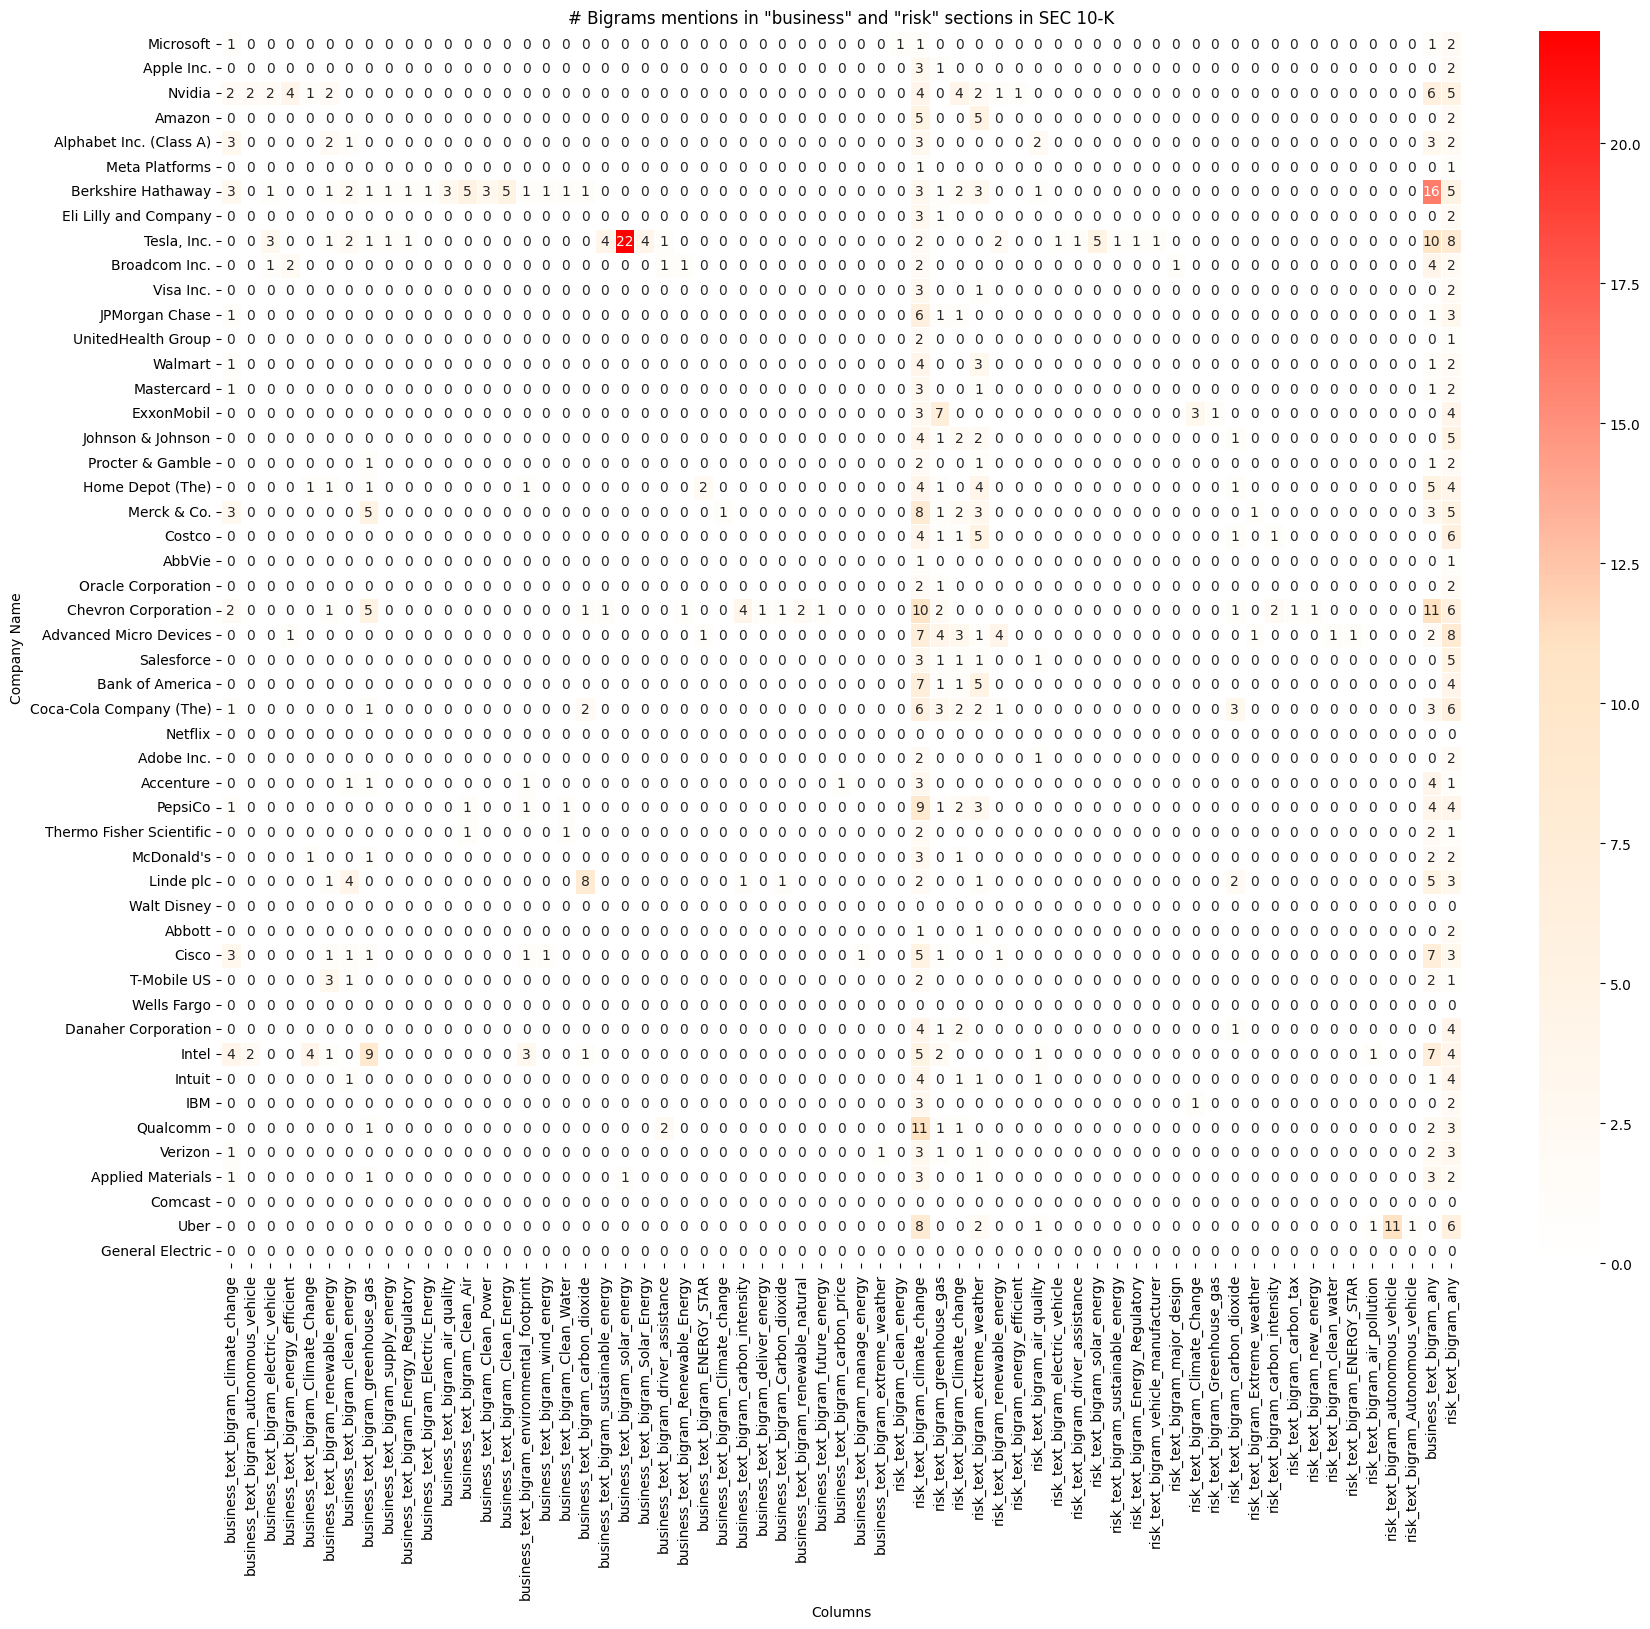

In [148]:
# Custom color map with grey for zero values
cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['white', 'bisque', 'red'])

# Select columns starting with "business_text_bigram_" or "risk_text_bigram_"
cols_to_include = [col for col in df.columns if col.startswith("business_text_bigram_") or col.startswith("risk_text_bigram_")]
cols_to_include.append("company_name")

# Create DataFrame with selected columns
heatmap_data = df[cols_to_include]

# Set "company_name" as the index
heatmap_data.set_index("company_name", inplace=True)

# Create the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".0f", linewidths=.5)
plt.title('# Bigrams mentions in "business" and "risk" sections in SEC 10-K')
plt.xlabel('Columns')
plt.ylabel('Company Name')  # Changed ylabel to "Company Name"
plt.show()

In [149]:
df['biz_with_no_bigram_mentions']=np.where(df['business_text_bigram_any']==0,1,0)
df['risk_with_no_bigram_mentions']=np.where(df['risk_text_bigram_any']==0,1,0)
df['biz_to_risk_bigram_mention_ratio']=df['risk_text_bigram_any']/df['business_text_bigram_any']+0.0000001
df['biz_to_risk_bigram_mention_diff']=df['risk_text_bigram_any']-df['business_text_bigram_any']
df['bigram_more_biz_or_risk']=np.where(df['risk_text_bigram_any']<=df['business_text_bigram_any'],1,0)


<ipython-input-150-809243aa563a>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['business_text_bigram_any'], kde=False, bins=20, color='blue')
<ipython-input-150-809243aa563a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['risk_text_bigram_any'], kde=False, bins=20, color='blue')


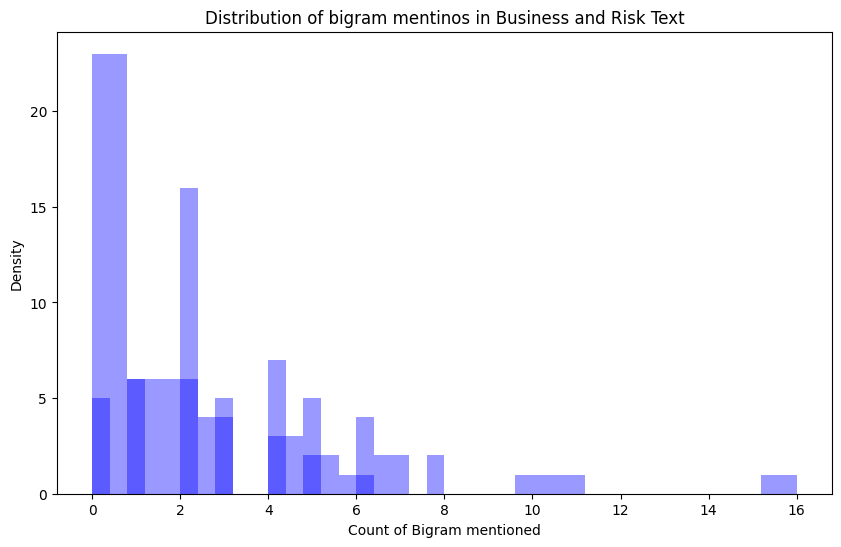

In [150]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the distribution
sns.distplot(df['business_text_bigram_any'], kde=False, bins=20, color='blue')
sns.distplot(df['risk_text_bigram_any'], kde=False, bins=20, color='blue')

# Add labels and title
plt.title('Distribution of bigram mentinos in Business and Risk Text')
plt.xlabel('Count of Bigram mentioned')
plt.ylabel('Density')

# Show the plot
plt.show()


<ipython-input-151-a92e3f5531b2>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['business_text_bigram_any'], hist=False, kde=True, bins=20, color='blue', label='Business', hist_kws={'alpha': 0.5})
<ipython-input-151-a92e3f5531b2>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

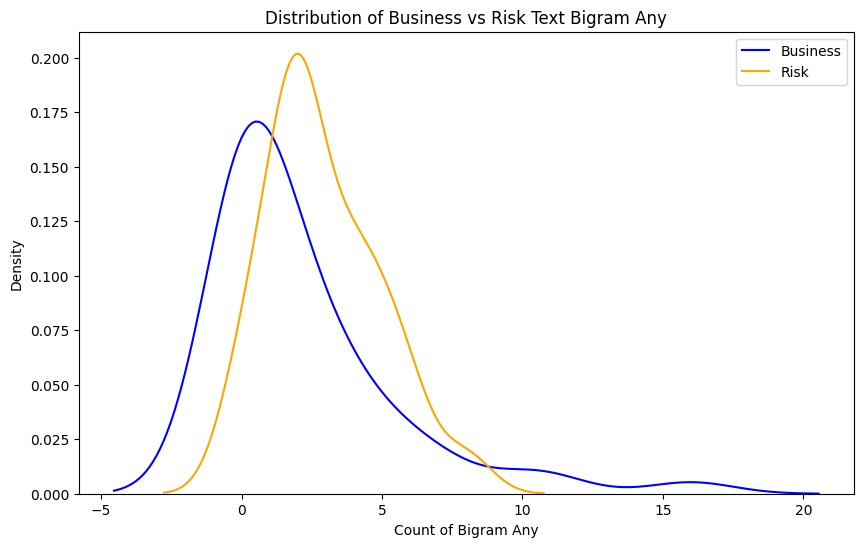

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the columns "business_text_bigram_any" and "risk_text_bigram_any"
# Replace df with your actual DataFrame name

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the distribution for business with shaded region
sns.distplot(df['business_text_bigram_any'], hist=False, kde=True, bins=20, color='blue', label='Business', hist_kws={'alpha': 0.5})

# Plot the distribution for risk with shaded region
sns.distplot(df['risk_text_bigram_any'], hist=False, kde=True, bins=20, color='orange', label='Risk', hist_kws={'alpha': 0.5})

# Add labels and title
plt.title('Distribution of Business vs Risk Text Bigram Any')
plt.xlabel('Count of Bigram Any')
plt.ylabel('Density')

plt.legend()
# Show the plot
plt.show()


<ipython-input-152-cbb54517cfda>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['business_text_bigram_any'], hist=True, kde=True, bins=20, color='blue', label='Business', hist_kws={'alpha': 0.5}, ax=axes[0])
<ipython-input-152-cbb54517cfda>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

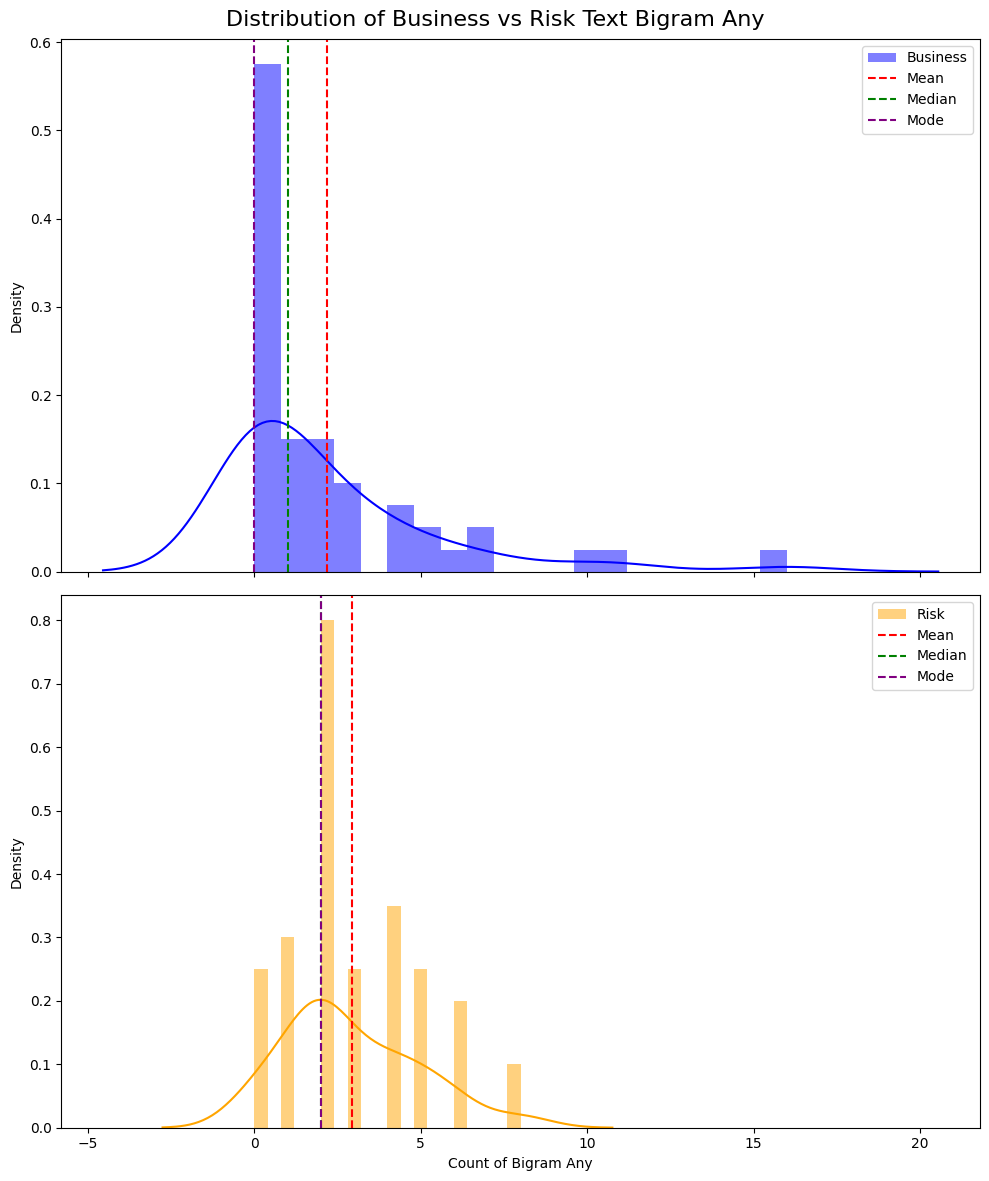

In [152]:
# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot the distribution for business with shaded region
sns.distplot(df['business_text_bigram_any'], hist=True, kde=True, bins=20, color='blue', label='Business', hist_kws={'alpha': 0.5}, ax=axes[0])

# Add vertical lines for mean, median, and mode
axes[0].axvline(df['business_text_bigram_any'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(df['business_text_bigram_any'].median(), color='green', linestyle='--', label='Median')
axes[0].axvline(df['business_text_bigram_any'].mode()[0], color='purple', linestyle='--', label='Mode')

# Add legend for the first subplot
axes[0].legend()

# Plot the distribution for risk with shaded region
sns.distplot(df['risk_text_bigram_any'], hist=True, kde=True, bins=20, color='orange', label='Risk', hist_kws={'alpha': 0.5}, ax=axes[1])

# Add vertical lines for mean, median, and mode
axes[1].axvline(df['risk_text_bigram_any'].mean(), color='red', linestyle='--', label='Mean')
axes[1].axvline(df['risk_text_bigram_any'].median(), color='green', linestyle='--', label='Median')
axes[1].axvline(df['risk_text_bigram_any'].mode()[0], color='purple', linestyle='--', label='Mode')

# Add legend for the second subplot
axes[1].legend()

# Add labels and title to the figure
fig.suptitle('Distribution of Business vs Risk Text Bigram Any', fontsize=16)
axes[1].set_xlabel('Count of Bigram Any')
axes[0].set_ylabel('Density')
axes[1].set_ylabel('Density')

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-153-c9379bdc95a0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['business_text_bigram_any'], hist=True, kde=True, bins=20, color='blue', label='Business', hist_kws={'alpha': 0.5}, ax=axes[0])
<ipython-input-153-c9379bdc95a0>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

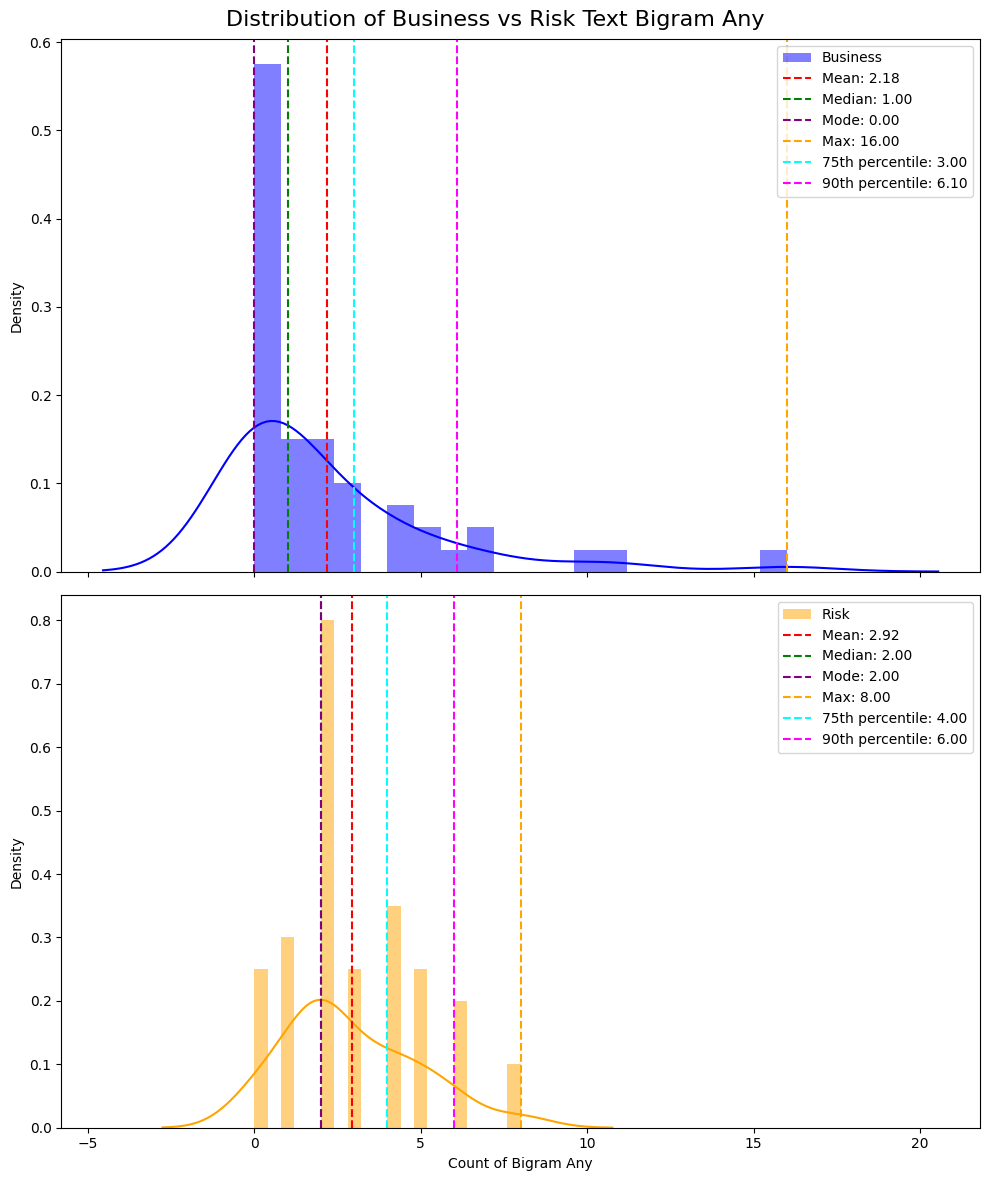

In [153]:
# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot the distribution for business with shaded region
sns.distplot(df['business_text_bigram_any'], hist=True, kde=True, bins=20, color='blue', label='Business', hist_kws={'alpha': 0.5}, ax=axes[0])

# Add vertical lines for mean, median, mode, max, 75th percentile, and 90th percentile
mean_business = df['business_text_bigram_any'].mean()
median_business = df['business_text_bigram_any'].median()
mode_business = df['business_text_bigram_any'].mode()[0]
max_business = df['business_text_bigram_any'].max()
percentile_75_business = np.percentile(df['business_text_bigram_any'], 75)
percentile_90_business = np.percentile(df['business_text_bigram_any'], 90)
for val, color, label in zip([mean_business, median_business, mode_business, max_business, percentile_75_business, percentile_90_business], ['red', 'green', 'purple', 'orange', 'cyan', 'magenta'], ['Mean', 'Median', 'Mode', 'Max', '75th percentile', '90th percentile']):
    axes[0].axvline(val, color=color, linestyle='--', label=f'{label}: {val:.2f}')

# Add legend for the first subplot
axes[0].legend()

# Plot the distribution for risk with shaded region
sns.distplot(df['risk_text_bigram_any'], hist=True, kde=True, bins=20, color='orange', label='Risk', hist_kws={'alpha': 0.5}, ax=axes[1])

# Add vertical lines for mean, median, mode, max, 75th percentile, and 90th percentile
mean_risk = df['risk_text_bigram_any'].mean()
median_risk = df['risk_text_bigram_any'].median()
mode_risk = df['risk_text_bigram_any'].mode()[0]
max_risk = df['risk_text_bigram_any'].max()
percentile_75_risk = np.percentile(df['risk_text_bigram_any'], 75)
percentile_90_risk = np.percentile(df['risk_text_bigram_any'], 90)
for val, color, label in zip([mean_risk, median_risk, mode_risk, max_risk, percentile_75_risk, percentile_90_risk], ['red', 'green', 'purple', 'orange', 'cyan', 'magenta'], ['Mean', 'Median', 'Mode', 'Max', '75th percentile', '90th percentile']):
    axes[1].axvline(val, color=color, linestyle='--', label=f'{label}: {val:.2f}')

# Add legend for the second subplot
axes[1].legend()

# Add labels and title to the figure
fig.suptitle('Distribution of Business vs Risk Text Bigram Any', fontsize=16)
axes[1].set_xlabel('Count of Bigram Any')
axes[0].set_ylabel('Density')
axes[1].set_ylabel('Density')

# Show the plot
plt.tight_layout()
plt.show()


In [154]:
df.columns

Index(['Unnamed: 0', 'Rank', 'company_name', 'stock_symbol', 'website',
       'market_cap', 'market_cap_pretty', 'Filed for Year', 'Filed',
       'Filed For Date', 'SEC_10K', 'business_text', 'risk_text',
       'business_text_clean', 'risk_text_clean',
       'business_text_climatechange_count', 'risk_text_climatechange_count',
       'business_text_greenhouse_count', 'risk_text_greenhouse_count',
       'business_text_sustainability_count', 'risk_text_sustainability_count',
       'business_any_keyword', 'risk_any_keyword', 'business_text_tokens',
       'business_text_bigrams', 'risk_text_tokens', 'risk_text_bigrams',
       'business_text_bigram_climate_change',
       'business_text_bigram_autonomous_vehicle',
       'business_text_bigram_electric_vehicle',
       'business_text_bigram_energy_efficient',
       'business_text_bigram_Climate_Change',
       'business_text_bigram_renewable_energy',
       'business_text_bigram_clean_energy',
       'business_text_bigram_greenhouse

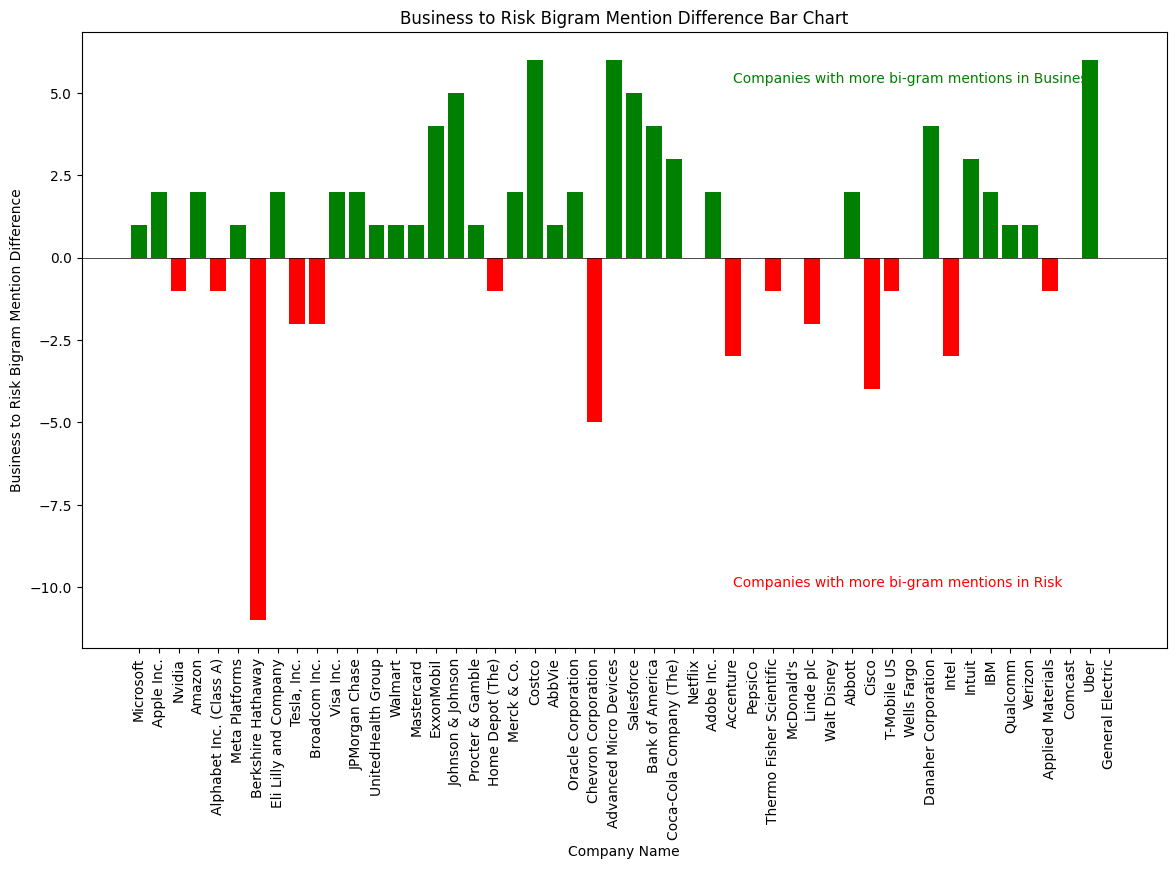

In [155]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the "biz_to_risk_bigram_mention_diff" column
# Replace df with your actual DataFrame name

# Define colors based on difference values
colors = ['red' if diff < 0 else 'green' for diff in df['biz_to_risk_bigram_mention_diff']]

# Create the bar plot
plt.figure(figsize=(14, 8))
bars = plt.bar(df['company_name'], df['biz_to_risk_bigram_mention_diff'], color=colors)

# Add a horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.5)

# Add labels and title
plt.xlabel('Company Name')
plt.ylabel('Business to Risk Bigram Mention Difference')
plt.title('Business to Risk Bigram Mention Difference Bar Chart')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add text annotation for the entire plot
plt.text(30,5.3, 'Companies with more bi-gram mentions in Business' ,color='green')
plt.text(30,-10, 'Companies with more bi-gram mentions in Risk' ,color='red')

# Show the plot
plt.show()


In [156]:
# Function to count unique companies with mentions of each bigram in both "business_text" and "risk_text" columns
def count_unique_companies(bigram):
    business_count = len(set(df.loc[~df['business_text'].isnull() & df['business_text'].str.contains(bigram), 'business_text']))
    risk_count = len(set(df.loc[~df['risk_text'].isnull() & df['risk_text'].str.contains(bigram), 'risk_text']))
    return business_count, risk_count

# Create a DataFrame to store the counts
bi_gram_rank = pd.DataFrame(columns=['Bigram', 'Business_Text_Count', 'Risk_Text_Count'])

# Calculate counts for each bigram
for bigram in bigrams_list:
    business_count, risk_count = count_unique_companies(bigram)
    bi_gram_rank = bi_gram_rank.append({'Bigram': bigram, 'Business_Text_Count': business_count, 'Risk_Text_Count': risk_count}, ignore_index=True)


<ipython-input-156-6593dd4594b7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bi_gram_rank = bi_gram_rank.append({'Bigram': bigram, 'Business_Text_Count': business_count, 'Risk_Text_Count': risk_count}, ignore_index=True)
<ipython-input-156-6593dd4594b7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bi_gram_rank = bi_gram_rank.append({'Bigram': bigram, 'Business_Text_Count': business_count, 'Risk_Text_Count': risk_count}, ignore_index=True)
<ipython-input-156-6593dd4594b7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bi_gram_rank = bi_gram_rank.append({'Bigram': bigram, 'Business_Text_Count': business_count, 'Risk_Text_Count': risk_count}, ignore_index=True)
<ipython-input-156-6593dd4594b7>:13: FutureWarning: 

In [164]:
bi_gram_rank=bi_gram_rank.sort_values(by="Business_Text_Count",ascending=False)
bi_gram_rank['Business_Text_Rank'] = bi_gram_rank['Business_Text_Count'].rank(ascending=False, method='min').astype(int)
bi_gram_rank['Risk_Text_Rank'] = bi_gram_rank['Risk_Text_Count'].rank(ascending=False, method='min').astype(int)

bi_gram_rank.set_index('Bigram', inplace=True)

bi_gram_rank

,Business_Text_Count,Risk_Text_Count,Business_Text_Rank,Risk_Text_Rank
Bigram,,,,
climate change,16,45,1,1
greenhouse gas,14,22,2,2
renewable energy,10,5,3,8
gas emission,9,19,4,4
clean energy,8,1,5,15
...,...,...,...,...
gas vehicle,0,0,35,28
area energy,0,0,35,28
compare conventional,0,0,35,28


In [167]:
bi_gram_rank[['Business_Text_Rank','Risk_Text_Rank']].head(20)

,Business_Text_Rank,Risk_Text_Rank
Bigram,,
climate change,1,1
greenhouse gas,2,2
renewable energy,3,8
gas emission,4,4
clean energy,5,15
carbon emission,6,15
environmental footprint,6,28
sustainability goal,8,9
carbon dioxide,8,5


In [168]:
bi_gram_rank[['Risk_Text_Rank','Business_Text_Rank'
]].sort_values(by="Risk_Text_Rank",ascending=True).head(20)

,Risk_Text_Rank,Business_Text_Rank
Bigram,,
climate change,1,1
greenhouse gas,2,2
extreme weather,2,22
gas emission,4,4
carbon tax,5,35
air quality,5,22
carbon dioxide,5,8
renewable energy,8,3
sustainability goal,9,8


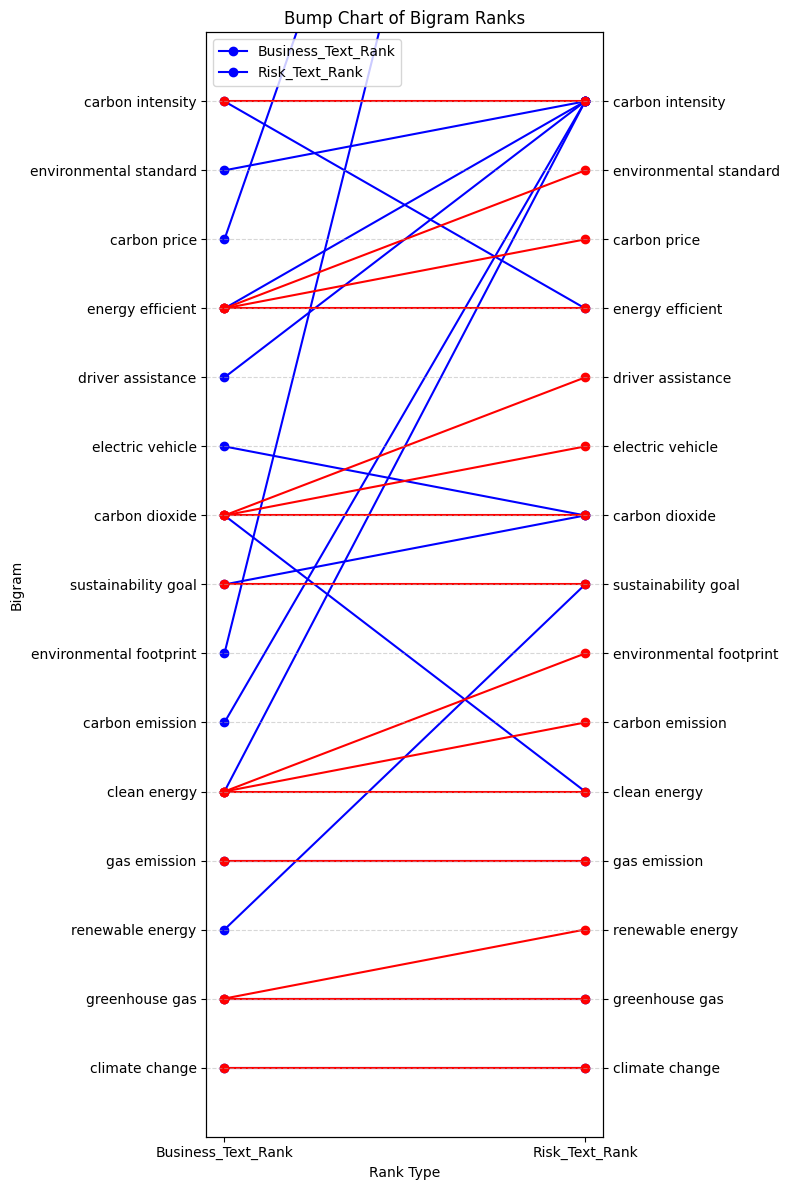

In [161]:


# Sort the DataFrame based on "Business_Text_Rank" in ascending order
business_rank = bi_gram_rank.sort_values(by='Business_Text_Rank', ascending=False).tail(15)

# Sort the DataFrame based on "Risk_Text_Rank" in ascending order
risk_rank = bi_gram_rank.sort_values(by='Risk_Text_Rank', ascending=False).tail(15)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 12))

# Plot the lines for "Business_Text_Rank"
for i, bigram in enumerate(business_rank.index):
    ax.plot([1, 2], [i + 1, len(business_rank) - business_rank.loc[bigram, 'Risk_Text_Rank'] + 1],
            marker='o', color='blue')

# Plot the lines for "Risk_Text_Rank"
for i, bigram in enumerate(risk_rank.index):
    ax.plot([1, 2], [len(risk_rank) - risk_rank.loc[bigram, 'Risk_Text_Rank'] + 1, i + 1],
            marker='o', color='red')

# Set x-axis ticks and labels
plt.xticks([1, 2], ['Business_Text_Rank', 'Risk_Text_Rank'])

# Set y-axis limits and ticks
plt.ylim(len(business_rank) + 1, 0)  # Reverse y-axis
plt.yticks(range(1, len(business_rank) + 1), business_rank.index)  # Set y-axis ticks to the bigram labels


# Add labels and title
plt.xlabel('Rank Type')
plt.ylabel('Bigram')
plt.title('Bump Chart of Bigram Ranks')

# Add legend
plt.legend(['Business_Text_Rank', 'Risk_Text_Rank'], loc='upper left')

# Create dual y-axis on the right side
ax2 = ax.twinx()
ax2.set_ylim(len(business_rank) + 1, 0)  # Reverse y-axis
ax2.set_yticks(range(1, len(business_rank) + 1))
ax2.set_yticklabels(business_rank.index)

# Show the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# CSR keywords explore



In [169]:
csr_keyword_list = [ "Corporate Social Responsibility", "corporate social responsibility", "CSR", "csr"]

def count_csr_mentions(row):
    # Initialize count
    count = 0
    # Loop through text columns and count occurrences of CSR keywords
    for col in ['business_text_clean', 'risk_text_clean']:
        text = row[col]
        for keyword in csr_keyword_list:
            count += text.lower().count(keyword.lower())
    return count

# Create new column 'number_mentions_csr_keywords'
df['number_mentions_csr_keywords'] = df.apply(count_csr_mentions, axis=1)

df['number_mentions_csr_keywords'].value_counts()

0    46
4     2
6     1
2     1
Name: number_mentions_csr_keywords, dtype: int64

In [170]:
df[df['number_mentions_csr_keywords']==0].company_name.tolist()

['Apple Inc.',
 'Nvidia',
 'Amazon',
 'Alphabet Inc. (Class A)',
 'Meta Platforms',
 'Berkshire Hathaway',
 'Eli Lilly and Company',
 'Tesla, Inc.',
 'Broadcom Inc.',
 'Visa Inc.',
 'UnitedHealth Group',
 'Walmart',
 'ExxonMobil',
 'Johnson & Johnson',
 'Procter & Gamble',
 'Home Depot (The)',
 'Merck & Co.',
 'Costco',
 'AbbVie',
 'Oracle Corporation',
 'Chevron Corporation',
 'Advanced Micro Devices',
 'Salesforce',
 'Bank of America',
 'Coca-Cola Company (The)',
 'Netflix',
 'Adobe Inc.',
 'Accenture',
 'PepsiCo',
 'Thermo Fisher Scientific',
 "McDonald's",
 'Linde plc',
 'Walt Disney',
 'Abbott',
 'T-Mobile US',
 'Wells Fargo',
 'Danaher Corporation',
 'Intel',
 'Intuit',
 'IBM',
 'Qualcomm',
 'Verizon',
 'Applied Materials',
 'Comcast',
 'Uber',
 'General Electric']

In [171]:
df[df['number_mentions_csr_keywords']!=0].company_name.tolist()

['Microsoft', 'JPMorgan Chase', 'Mastercard', 'Cisco']

In [172]:
# Took a closer look, CSR keywords are not always used even there are mentions of similar sentiment.

# Drop this column
df.drop(columns=['number_mentions_csr_keywords'], inplace=True)
